<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<font size="10"><b>Catch Me If You Can ("Alice")</b></font>

# Load lib

In [1]:
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from itertools import groupby
import numpy as np
import pandas as pd
import pickle
import re

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.sparse import csr_matrix, hstack

from statsmodels import api as sm

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, log_loss, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier

# UNDERSTANDING DATA

In [2]:
train = pd.read_csv('/Users/greygreywolf/Downloads/catch/train_sessions.csv', index_col='session_id', parse_dates=['time1'])
test = pd.read_csv('/Users/greygreywolf/Downloads/catch/test_sessions.csv', index_col='session_id', parse_dates=['time1'])

In [3]:
print('This is train dataset\n')
train.head(4)

This is train dataset



,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0


In [4]:
print('This is test dataset\n')
test.head(4)

This is test dataset



,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23


In [5]:
print('This is info about train dataset\n\n')
train.info()

This is info about train dataset


<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  object        
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  object        
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  object        
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  object        
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  object        
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  object        
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  object        
 16  site9   233084 non-null  float64       

In [6]:
print('This is info about test dataset\n\n')
test.info()

This is info about test dataset


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   site1   82797 non-null  int64         
 1   time1   82797 non-null  datetime64[ns]
 2   site2   81308 non-null  float64       
 3   time2   81308 non-null  object        
 4   site3   80075 non-null  float64       
 5   time3   80075 non-null  object        
 6   site4   79182 non-null  float64       
 7   time4   79182 non-null  object        
 8   site5   78341 non-null  float64       
 9   time5   78341 non-null  object        
 10  site6   77566 non-null  float64       
 11  time6   77566 non-null  object        
 12  site7   76840 non-null  float64       
 13  time7   76840 non-null  object        
 14  site8   76151 non-null  float64       
 15  time8   76151 non-null  object        
 16  site9   75484 non-null  float64       
 17  time9   75484 no

# PREPROCESSING

## GIVE ORDER

In [7]:
def give_order(df):
    if (df.time1.is_monotonic) is True:
        print('\nDate in order:')
        new_df = df
        display(new_df.head(3))
    elif (df.time1.is_monotonic) is not True:
        print('\nDate not in order')
        display(df.head(3))
        new_df = df.sort_values(by='time1', ascending=True)
        print('\n Now date in order:')
        display(new_df.head(3))
    return new_df

In [8]:
train = give_order(train)


Date not in order


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0



 Now date in order:


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0


## RENAME COLUMNS

In [9]:
def give_correct_name_for_columns(df):
    
    print('\n===Old columns name===')
    print()
    print(df.columns)
    new_names = []
    old_names = df.columns
    for old_name in old_names:
        if (old_name[-1].isnumeric()) and (not old_name[-2].isnumeric()):
            new_name = old_name[:-1] + '_' + old_name[-1:]
            new_names.append(new_name)
        elif (old_name[-1].isnumeric()) and (old_name[-2].isnumeric()):
            new_name = old_name[:-2] + '_' + old_name[-2:]
            new_names.append(new_name)
        else:
            new_names.append(old_name)
    print('\n\n=== New columns name=== \n\n', new_names)
    for i in range(len(df.columns)):
        df.rename(columns={f'{old_names[i]}' : f'{new_names[i]}'}, inplace=True)
    return df

In [10]:
train = give_correct_name_for_columns(train)


===Old columns name===

Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10', 'target'],
      dtype='object')


=== New columns name=== 

 ['site_1', 'time_1', 'site_2', 'time_2', 'site_3', 'time_3', 'site_4', 'time_4', 'site_5', 'time_5', 'site_6', 'time_6', 'site_7', 'time_7', 'site_8', 'time_8', 'site_9', 'time_9', 'site_10', 'time_10', 'target']


In [11]:
test = give_correct_name_for_columns(test)


===Old columns name===

Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10'],
      dtype='object')


=== New columns name=== 

 ['site_1', 'time_1', 'site_2', 'time_2', 'site_3', 'time_3', 'site_4', 'time_4', 'site_5', 'time_5', 'site_6', 'time_6', 'site_7', 'time_7', 'site_8', 'time_8', 'site_9', 'time_9', 'site_10', 'time_10']


## SITE_I

In [12]:
sites = ['site_%i'% i for i in range(1,11)]

In [13]:
train[sites] = train[sites].fillna(0).astype('int')
test[sites] = test[sites].fillna(0).astype('int')

In [14]:
print('\nNAN in Train -', train.isna().sum().sum())
print('\nNAN in Test -', test.isna().sum().sum())


NAN in Train - 122730

NAN in Test - 45420


In [15]:
with open('/Users/greygreywolf/Downloads/catch/' + 'site_dic.pkl', 'rb') as site_dic:
    dictionary_of_sites = pickle.load(site_dic)

In [16]:
print('Example of sites:')
print('='*20)
[site for site in dictionary_of_sites.items()][:5]

Example of sites:


[('www.abmecatronique.com', 25075),
 ('groups.live.com', 13997),
 ('majeureliguefootball.wordpress.com', 42436),
 ('cdt46.media.tourinsoft.eu', 30911),
 ('www.hdwallpapers.eu', 8104)]

In [17]:
dictionary_of_sites = {v:k for (k, v) in dictionary_of_sites.items()}

In [18]:
print(f'Example of sites after inversion (Total size - {len(dictionary_of_sites)}):')
print('='*60)
print([site for site in dictionary_of_sites.items()][:5])
print('\n Min key (site id) in dict -', min(list(dictionary_of_sites.keys())))
print('\n Max key (site id) in dict -', max(list(dictionary_of_sites.keys())))

Example of sites after inversion (Total size - 48371):
[(25075, 'www.abmecatronique.com'), (13997, 'groups.live.com'), (42436, 'majeureliguefootball.wordpress.com'), (30911, 'cdt46.media.tourinsoft.eu'), (8104, 'www.hdwallpapers.eu')]

 Min key (site id) in dict - 1

 Max key (site id) in dict - 48371


In [19]:
dictionary_of_sites[0] = 'empty'
print(f'Min key (site id) in dict - {min(list(dictionary_of_sites.keys()))}, key - "{dictionary_of_sites[0]}"')

Min key (site id) in dict - 0, key - "empty"


In [20]:
train[sites] = train[sites].apply(lambda site: site.map(dictionary_of_sites))
test[sites] = test[sites].apply(lambda site: site.map(dictionary_of_sites))

In [21]:
train.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_6,site_7,time_7,site_8,time_8,site_9,time_9,site_10,time_10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,safebrowsing.clients.google.com,2013-01-12 08:05:57,safebrowsing-cache.google.com,2013-01-12 08:05:57,empty,NaN,empty,NaN,empty,NaN,...,NaN,empty,NaN,empty,NaN,empty,NaN,empty,NaN,0
54843,safebrowsing.clients.google.com,2013-01-12 08:37:23,safebrowsing-cache.google.com,2013-01-12 08:37:23,safebrowsing.clients.google.com,2013-01-12 09:07:07,safebrowsing-cache.google.com,2013-01-12 09:07:09,empty,NaN,...,NaN,empty,NaN,empty,NaN,empty,NaN,empty,NaN,0


In [22]:
test.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,site_6,time_6,site_7,time_7,site_8,time_8,site_9,time_9,site_10,time_10
session_id,,,,,,,,,,,,,,,,,,,,
1,www.facebook.com,2014-10-04 11:19:53,s-static.ak.facebook.com,2014-10-04 11:19:53,apis.google.com,2014-10-04 11:19:54,c1.adform.net,2014-10-04 11:19:54,www.google.com,2014-10-04 11:19:54,mpp2.vindicosuite.com,2014-10-04 11:19:54,api.nanigans.com,2014-10-04 11:19:54,www.google.fr,2014-10-04 11:19:54,secure.vistaprint.fr,2014-10-04 11:20:00,www.vistaprint.fr,2014-10-04 11:20:00
2,annotathon.org,2014-07-03 11:00:28,annotathon.org,2014-07-03 11:00:53,annotathon.org,2014-07-03 11:00:58,annotathon.org,2014-07-03 11:01:06,annotathon.org,2014-07-03 11:01:09,annotathon.org,2014-07-03 11:01:10,annotathon.org,2014-07-03 11:01:23,annotathon.org,2014-07-03 11:01:29,annotathon.org,2014-07-03 11:01:30,annotathon.org,2014-07-03 11:01:53


## TIME_I

In [23]:
times = ['time_%i'% i for i in range(1,11)]

In [24]:
train[times] = train[times].apply(pd.to_datetime)
test[times] = test[times].apply(pd.to_datetime)

In [25]:
print('All years in Train -', train['time_1'].dt.year.unique())
for year in train['time_1'].dt.year.unique():
    print(f'All month in Train for {year} year -', sorted(train[(train['time_1'] > f'{year}-01-01') & (train['time_1'] < f'{year}-12-31')]['time_1'].dt.month.unique()))
print('-------'*10)
print('All number of months in Train -', len(train['time_1'].dt.to_period('M').unique()))
print()
print('\nAll years in Test -', test['time_1'].dt.year.unique())
for year in test['time_1'].dt.year.unique():
    print(f'All month in Test for {year} year -', sorted(test[(test['time_1'] > f'{year}-01-01') & (test['time_1'] < f'{year}-12-31')]['time_1'].dt.month.unique()))
print('-------'*10)
print('All number of months in Test -', len(test['time_1'].dt.to_period('M').unique()))

All years in Train - [2013 2014]
All month in Train for 2013 year - [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
All month in Train for 2014 year - [1, 2, 3, 4]
----------------------------------------------------------------------
All number of months in Train - 16


All years in Test - [2014]
All month in Test for 2014 year - [5, 6, 7, 8, 9, 10, 11, 12]
----------------------------------------------------------------------
All number of months in Test - 8


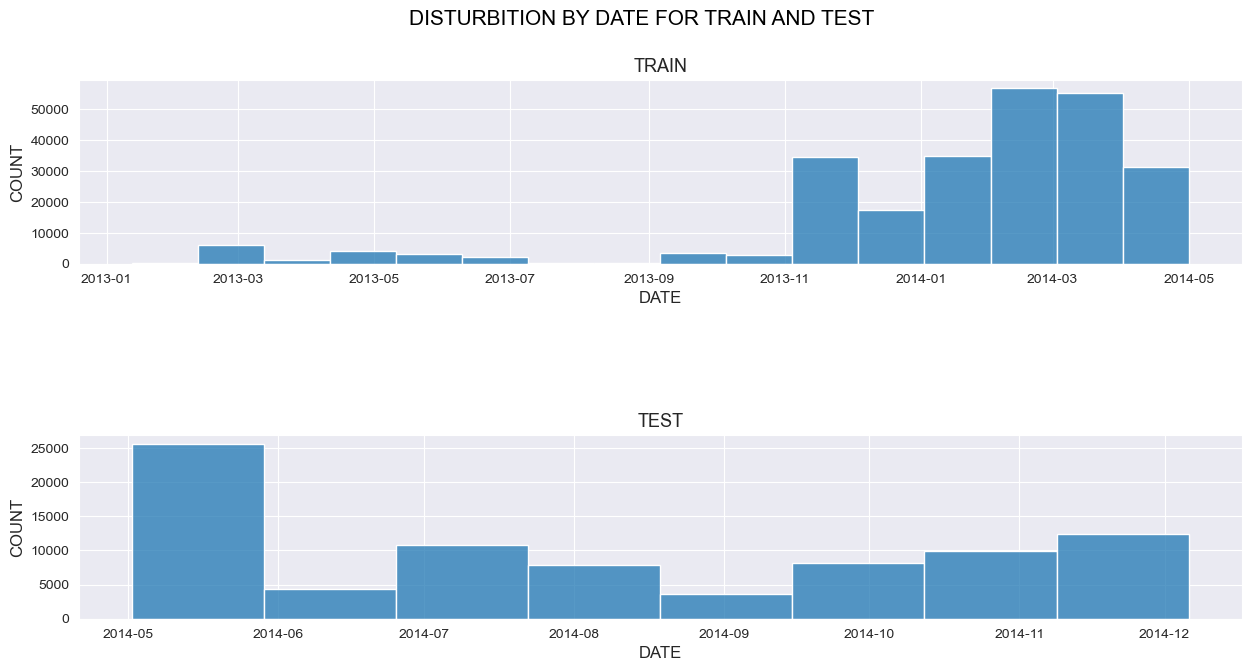

In [26]:
plt.figure(figsize=[15, 7])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.93)
plt.suptitle('DISTURBITION BY DATE FOR TRAIN AND TEST', fontsize=15)
sns.set_style('darkgrid')
plt.grid(True)
plt.subplot(2, 1, 1)
plt.title('TRAIN', fontsize=13)
sns.histplot(train['time_1'], bins=len(train['time_1'].dt.to_period('M').unique()))
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('DATE', fontsize=12)
plt.subplot(2, 1, 2)
plt.title('TEST', fontsize=13)
sns.histplot(test['time_1'], bins=len(test['time_1'].dt.to_period('M').unique()))
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('DATE', fontsize=12);

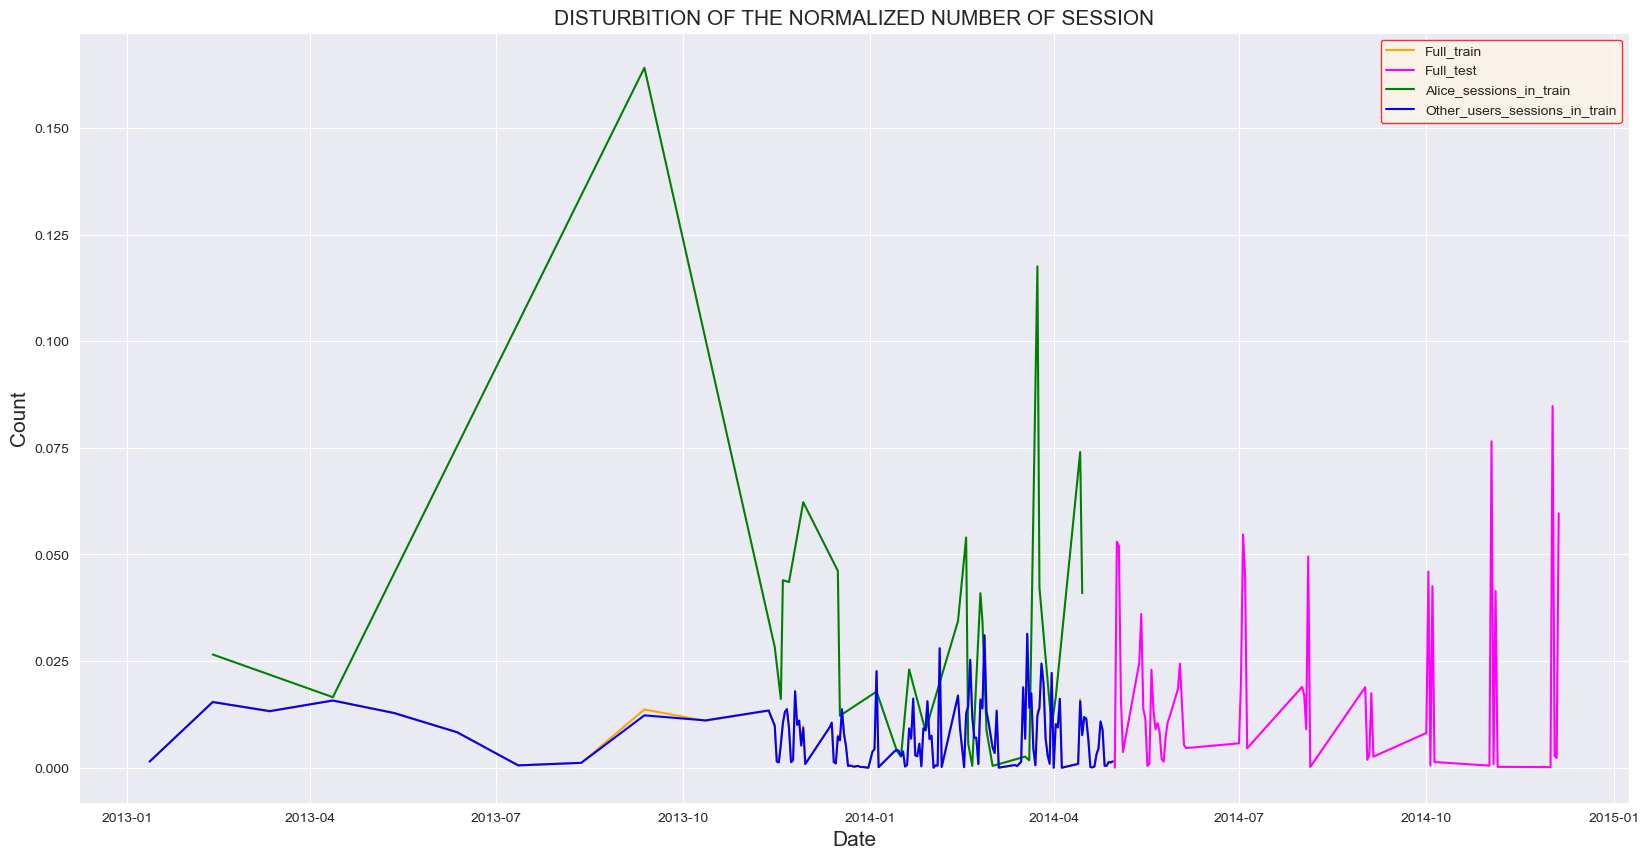

In [27]:
plt.figure(figsize=[20, 10])
sns.set_style('darkgrid')
plt.title('DISTURBITION OF THE NORMALIZED NUMBER OF SESSION', fontsize=15)
plt.plot(((pd.DatetimeIndex(train['time_1']).normalize() \
           .value_counts())/len(train)).sort_index().resample('1D').interpolate(),
        label='Full_train',
        color='orange')
plt.plot(((pd.DatetimeIndex(test['time_1']).normalize() \
           .value_counts())/len(test)).sort_index().resample('1D').interpolate(),
        label='Full_test',
        color='magenta')
plt.plot(((pd.DatetimeIndex(train.query('target==1')['time_1']) \
           .normalize().value_counts())/len(train.query('target==1'))).sort_index().resample('1D').interpolate(),
        label='Alice_sessions_in_train',
        color='green',
        alpha=1)
plt.plot(((pd.DatetimeIndex(train.query('target==0')['time_1']) \
           .normalize().value_counts())/len(train.query('target==0'))).sort_index().resample('1D').interpolate(),
        label='Other_users_sessions_in_train',
        color='blue',
        alpha=1)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend(edgecolor = 'r',
           facecolor = 'oldlace')
plt.show(True);

In [28]:
print('All days in Train by month in column "time_1"')
print('-------'*10)
for year in train['time_1'].dt.year.unique():
    for month in sorted(train[(train['time_1'] > f'{year}-01-01') & (train['time_1'] < f'{year}-12-31')]['time_1'].dt.month.unique()):
        print(f'All unique days in Train for {year} year in month №{month} -', sorted(train.loc[(train['time_1'].dt.month==month) & (train['time_1'].dt.year == year)]['time_1'].dt.day.unique()))
print()
print('All days in Test by month in column "time_1"')
print('-------'*10)
for year in test['time_1'].dt.year.unique():
    for month in sorted(test[(test['time_1'] > f'{year}-01-01') & (test['time_1'] < f'{year}-12-31')]['time_1'].dt.month.unique()):
        print(f'All unique days in Test for {year} year in month №{month} -', sorted(test.loc[(train['time_1'].dt.month==month) & (test['time_1'].dt.year == year)]['time_1'].dt.day.unique()))

All days in Train by month in column "time_1"
----------------------------------------------------------------------
All unique days in Train for 2013 year in month №1 - [12]
All unique days in Train for 2013 year in month №2 - [12]
All unique days in Train for 2013 year in month №3 - [12]
All unique days in Train for 2013 year in month №4 - [12]
All unique days in Train for 2013 year in month №5 - [12]
All unique days in Train for 2013 year in month №6 - [12]
All unique days in Train for 2013 year in month №7 - [12]
All unique days in Train for 2013 year in month №8 - [12]
All unique days in Train for 2013 year in month №9 - [12]
All unique days in Train for 2013 year in month №10 - [12]
All unique days in Train for 2013 year in month №11 - [12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
All unique days in Train for 2013 year in month №12 - [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 31]
All unique days in Train for 2014 year in month №1 - [2,

In [29]:
def fix_incorrect_date_formats(df):
    for time in times:
        df_with_column_time = df[time]
        df_with_column_time_fixed = df_with_column_time[df_with_column_time.dt.day <= 12]
        df_with_column_time_fixed = pd.to_datetime(df_with_column_time_fixed.apply(str), format='%Y-%d-%m %H:%M:%S')
        df.loc[df_with_column_time_fixed.index.values, time] = df_with_column_time_fixed
    return df

In [30]:
train = fix_incorrect_date_formats(train)
test = fix_incorrect_date_formats(test)

In [31]:
print('All years in Train after FIX -', train['time_1'].dt.year.unique())
for year in train['time_1'].dt.year.unique():
    print(f'All month in Train for {year} year after FIX -', sorted(train[(train['time_1'] > f'{year}-01-01') & (train['time_1'] < f'{year}-12-31')]['time_1'].dt.month.unique()))
print('-------'*10)
print('All number of months in Train after FIX -', len(train['time_1'].dt.to_period('M').unique()))
print()
print('\nAll years in Test after FIX -', test['time_1'].dt.year.unique())
for year in test['time_1'].dt.year.unique():
    print(f'All month in Test for {year} year after FIX -', sorted(test[(test['time_1'] > f'{year}-01-01') & (test['time_1'] < f'{year}-12-31')]['time_1'].dt.month.unique()))
print('-------'*10)
print('All number of months in Test after FIX -', len(test['time_1'].dt.to_period('M').unique()))

All years in Train after FIX - [2013 2014]
All month in Train for 2013 year after FIX - [11, 12]
All month in Train for 2014 year after FIX - [1, 2, 3, 4, 5]
----------------------------------------------------------------------
All number of months in Train after FIX - 7


All years in Test after FIX - [2014]
All month in Test for 2014 year after FIX - [1, 2, 3, 4, 5]
----------------------------------------------------------------------
All number of months in Test after FIX - 5


In [32]:
print('All days in Train by month in column "time_1" after FIX')
print('-------'*10)
for year in train['time_1'].dt.year.unique():
    for month in sorted(train[(train['time_1'] > f'{year}-01-01') & (train['time_1'] < f'{year}-12-31')]['time_1'].dt.month.unique()):
        print(f'All unique days in Train for {year} year in month №{month} -', sorted(train.loc[(train['time_1'].dt.month==month) & (train['time_1'].dt.year == year)]['time_1'].dt.day.unique()))
print()
print('All days in Test by month in column "time_1" after FIX')
print('-------'*10)
for year in test['time_1'].dt.year.unique():
    for month in sorted(test[(test['time_1'] > f'{year}-01-01') & (test['time_1'] < f'{year}-12-31')]['time_1'].dt.month.unique()):
        print(f'All unique days in Test for {year} year in month №{month} -', sorted(test.loc[(train['time_1'].dt.month==month) & (test['time_1'].dt.year == year)]['time_1'].dt.day.unique()))

All days in Train by month in column "time_1" after FIX
----------------------------------------------------------------------
All unique days in Train for 2013 year in month №11 - [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
All unique days in Train for 2013 year in month №12 - [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 31]
All unique days in Train for 2014 year in month №1 - [2, 4, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
All unique days in Train for 2014 year in month №2 - [1, 2, 3, 4, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
All unique days in Train for 2014 year in month №3 - [1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
All unique days in Train for 2014 year in month №4 - [1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
All unique days in Train for 2014 year in month №5 - [

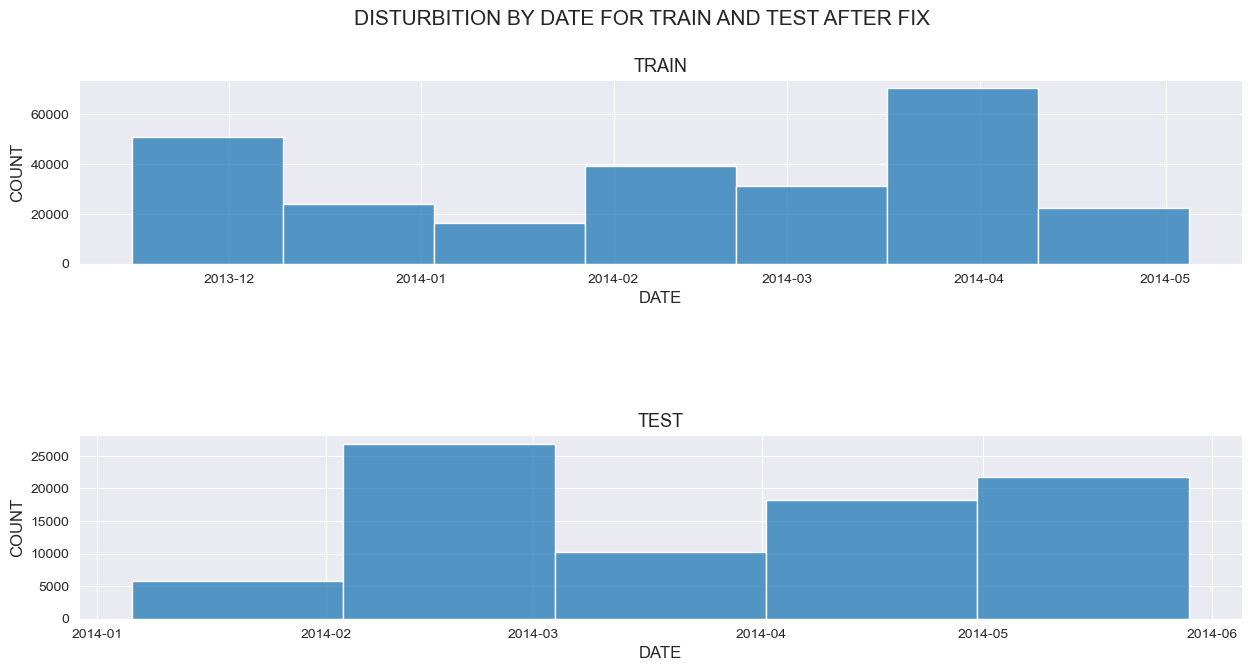

In [33]:
plt.figure(figsize=[15, 7])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.93)
plt.suptitle('DISTURBITION BY DATE FOR TRAIN AND TEST AFTER FIX', fontsize=15)
sns.set_style('darkgrid')
plt.grid(True)
plt.subplot(2, 1, 1)
plt.title('TRAIN', fontsize=13)
sns.histplot(train['time_1'], bins=len(train['time_1'].dt.to_period('M').unique()))
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('DATE', fontsize=12)
plt.subplot(2, 1, 2)
plt.title('TEST', fontsize=13)
sns.histplot(test['time_1'], bins=len(test['time_1'].dt.to_period('M').unique()))
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('DATE', fontsize=12);

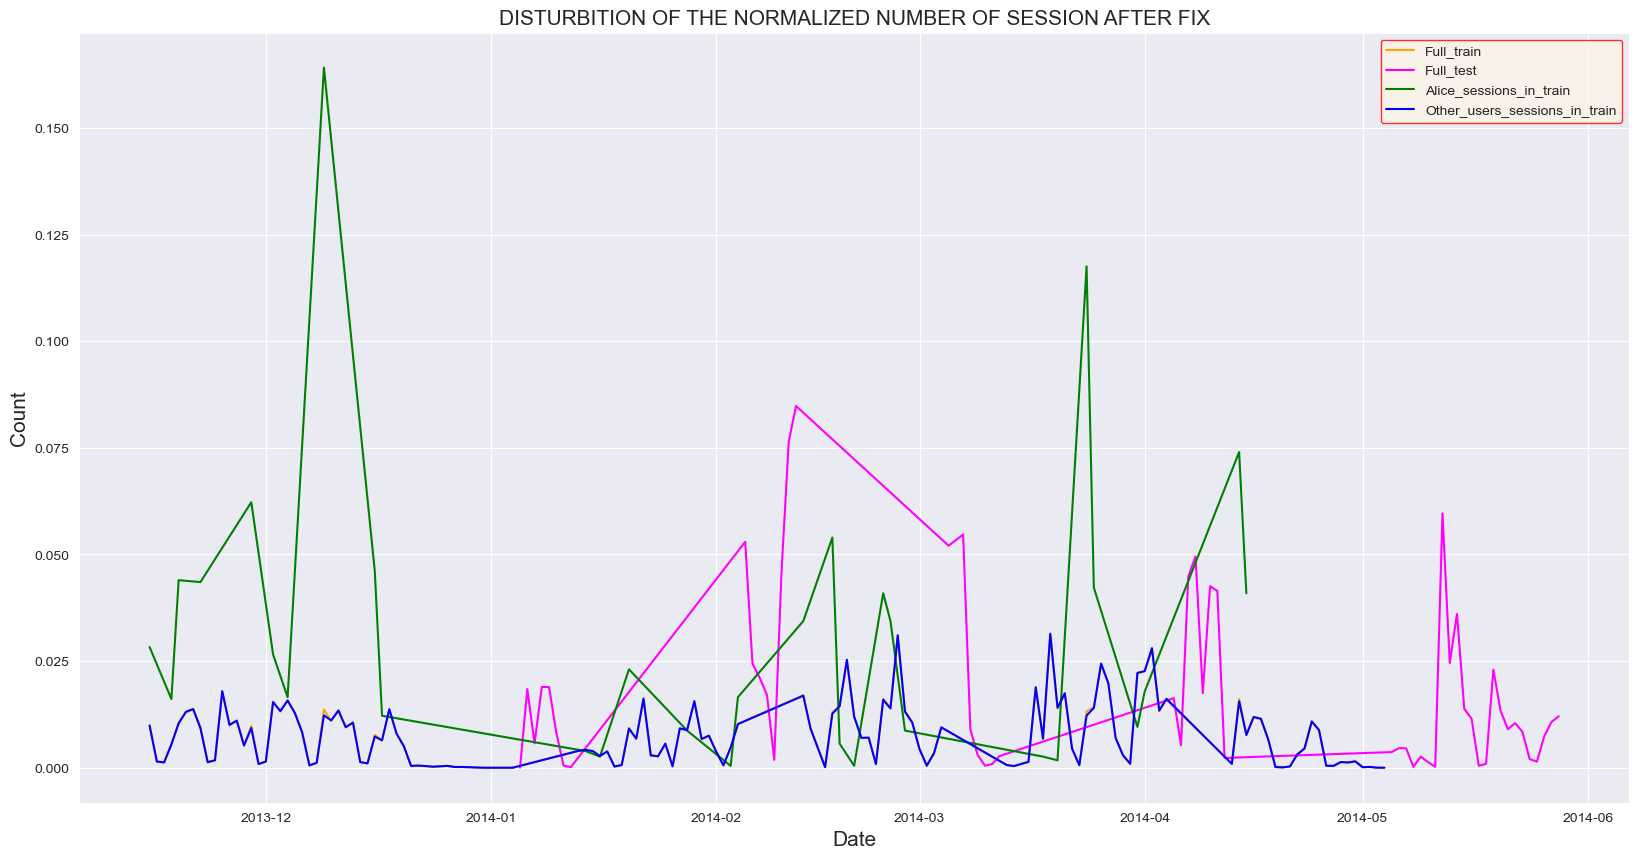

In [34]:
plt.figure(figsize=[20, 10])
sns.set_style('darkgrid')
plt.title('DISTURBITION OF THE NORMALIZED NUMBER OF SESSION AFTER FIX', fontsize=15)
plt.plot(((pd.DatetimeIndex(train['time_1']).normalize() \
           .value_counts())/len(train)).sort_index().resample('1D').interpolate(),
        label='Full_train',
        color='orange')
plt.plot(((pd.DatetimeIndex(test['time_1']).normalize() \
           .value_counts())/len(test)).sort_index().resample('1D').interpolate(),
        label='Full_test',
        color='magenta')
plt.plot(((pd.DatetimeIndex(train.query('target==1')['time_1']) \
           .normalize().value_counts())/len(train.query('target==1'))).sort_index().resample('1D').interpolate(),
        label='Alice_sessions_in_train',
        color='green',
        alpha=1)
plt.plot(((pd.DatetimeIndex(train.query('target==0')['time_1']) \
           .normalize().value_counts())/len(train.query('target==0'))).sort_index().resample('1D').interpolate(),
        label='Other_users_sessions_in_train',
        color='blue',
        alpha=1)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend(edgecolor = 'r',
           facecolor = 'oldlace')
plt.show(True);

In [35]:
del give_correct_name_for_columns, give_order, fix_incorrect_date_formats, year, month

## DUPLICATES

In [36]:
print('Number of explicit duplicates in Train -', train.duplicated().sum())

Number of explicit duplicates in Train - 28


In [37]:
train[train.duplicated()]['target'].value_counts()

0    28
Name: target, dtype: int64

In [38]:
train[train.duplicated()].head(10)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_6,site_7,time_7,site_8,time_8,site_9,time_9,site_10,time_10,target
session_id,,,,,,,,,,,,,,,,,,,,,
249860,www.arb-silva.de,2013-12-05 15:09:34,www.arb-silva.de,2013-12-05 15:09:36,www.arb-silva.de,2013-12-05 15:09:37,www.arb-silva.de,2013-12-05 15:09:44,www.arb-silva.de,2013-12-05 15:09:48,...,2013-12-05 15:09:54,www.arb-silva.de,2013-12-05 15:10:00,www.arb-silva.de,2013-12-05 15:10:06,www.arb-silva.de,2013-12-05 15:10:12,www.arb-silva.de,2013-12-05 15:10:18,0
3909,dl.javafx.com,2013-11-20 10:19:56,empty,NaT,empty,NaT,empty,NaT,empty,NaT,...,NaT,empty,NaT,empty,NaT,empty,NaT,empty,NaT,0
58240,javadl-esd.sun.com,2013-11-22 09:55:00,empty,NaT,empty,NaT,empty,NaT,empty,NaT,...,NaT,empty,NaT,empty,NaT,empty,NaT,empty,NaT,0
20450,javadl-esd.sun.com,2013-11-22 09:55:00,empty,NaT,empty,NaT,empty,NaT,empty,NaT,...,NaT,empty,NaT,empty,NaT,empty,NaT,empty,NaT,0
188327,javadl-esd.sun.com,2013-11-22 10:24:55,empty,NaT,empty,NaT,empty,NaT,empty,NaT,...,NaT,empty,NaT,empty,NaT,empty,NaT,empty,NaT,0
9653,javadl-esd.sun.com,2013-11-22 10:24:55,empty,NaT,empty,NaT,empty,NaT,empty,NaT,...,NaT,empty,NaT,empty,NaT,empty,NaT,empty,NaT,0
249557,javadl-esd.sun.com,2013-12-20 10:25:21,empty,NaT,empty,NaT,empty,NaT,empty,NaT,...,NaT,empty,NaT,empty,NaT,empty,NaT,empty,NaT,0
182804,javadl-esd.sun.com,2013-12-20 10:29:29,empty,NaT,empty,NaT,empty,NaT,empty,NaT,...,NaT,empty,NaT,empty,NaT,empty,NaT,empty,NaT,0
78753,ieonline.microsoft.com,2014-01-28 16:43:21,empty,NaT,empty,NaT,empty,NaT,empty,NaT,...,NaT,empty,NaT,empty,NaT,empty,NaT,empty,NaT,0


In [39]:
train = train.drop_duplicates()

# STATISTICAL DATA ANALYSIS

## MAKE TIME FEATURES

In [40]:
def make_time_features(df):
    df_with_time = df[times]
    lst_with_time_for_sites = []
    sessions_with_times = df[times].values.tolist()
    df['start_session'] = df['time_1'].apply(lambda x: x.hour).astype('int')
    df['day_of_week'] = df['time_1'].apply(lambda x: x.dayofweek).astype('int')
    df['month'] = df['time_1'].apply(lambda x: x.month).astype('int')
    df['year'] = df['time_1'].apply(lambda x: x.year).astype('int')
    df['day_of_month'] = df['time_1'].apply(lambda x: x.day).astype('int')
    df['month_year'] = df['time_1'].apply(lambda x: (100 * x.year + x.month) / 1e5)
    df['session_duration'] = np.log1p((df_with_time.max(axis=1) - df_with_time.min(axis=1)).astype('timedelta64[s]').astype('int').values)
    df['morning'] = df['time_1'].apply(lambda x: 1 if (x.hour >=7) & (x.hour <= 11) else 0).astype('int')
    df['day'] = df['time_1'].apply(lambda x: 1 if (x.hour >=12) & (x.hour <= 18) else 0).astype('int')
    df['evening'] = df['time_1'].apply(lambda x: 1 if (x.hour >=19) & (x.hour <= 23) else 0).astype('int')
    df['night'] = df['time_1'].apply(lambda x: 1 if (x.hour >=0) & (x.hour <= 6) else 0).astype('int')
    for sublist_number in range(len(sessions_with_times)):
        lst_with_time_for_sites.append([0]*9)
        for number_in_sublist in range(0,9):
            if (not pd.isnull(sessions_with_times[sublist_number][number_in_sublist])) and (not pd.isnull(sessions_with_times[sublist_number][number_in_sublist+1])):
                lst_with_time_for_sites[sublist_number][number_in_sublist] = np.log1p((sessions_with_times[sublist_number][number_in_sublist+1]-sessions_with_times[sublist_number][number_in_sublist])/1000000000)
    headers_for_df_with_times_for_per_site = ['time_for_site_' + str(i) for i in range(1,10)]
    df_with_times_for_per_site_in_session = pd.DataFrame((lst_with_time_for_sites), columns=headers_for_df_with_times_for_per_site, index=df.index)
    result = pd.concat([df, df_with_times_for_per_site_in_session], axis=1)
    return result

In [41]:
train = make_time_features(train)
test = make_time_features(test)

In [42]:
del make_time_features

## MAKE FEATURES BY SITES

In [43]:
def give_features_by_sites(df):
    lst_with_unique_sites_in_sessions = []  
    sessions_with_sites = df[sites].values.tolist()
    for i in range(len(sessions_with_sites)):
        unique_sites_in_session = set(sessions_with_sites[i])
        if 0 in unique_sites_in_session:
            unique_sites_in_session.remove(0)
            lst_with_unique_sites_in_sessions.append(len(unique_sites_in_session))
        else:
            lst_with_unique_sites_in_sessions.append(len(unique_sites_in_session))
    df['number_of_unique_sites'] = np.array(lst_with_unique_sites_in_sessions).reshape(df.shape[0],1)
    df['number_of_sites'] = df[sites].apply(lambda x: (~np.isin(x, ['empty'])).sum(), axis=1)
    return df

In [44]:
train = give_features_by_sites(train)
test = give_features_by_sites(test)

In [45]:
train.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_2,time_for_site_3,time_for_site_4,time_for_site_5,time_for_site_6,time_for_site_7,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites
session_id,,,,,,,,,,,,,,,,,,,,,
21669,safebrowsing.clients.google.com,2013-12-01 08:05:57,safebrowsing-cache.google.com,2013-12-01 08:05:57,empty,NaT,empty,NaT,empty,NaT,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3,2
54843,safebrowsing.clients.google.com,2013-12-01 08:37:23,safebrowsing-cache.google.com,2013-12-01 08:37:23,safebrowsing.clients.google.com,2013-12-01 09:07:07,safebrowsing-cache.google.com,2013-12-01 09:07:09,empty,NaT,...,7.487174,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,3,4


In [46]:
test.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_2,time_for_site_3,time_for_site_4,time_for_site_5,time_for_site_6,time_for_site_7,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites
session_id,,,,,,,,,,,,,,,,,,,,,
1,www.facebook.com,2014-04-10 11:19:53,s-static.ak.facebook.com,2014-04-10 11:19:53,apis.google.com,2014-04-10 11:19:54,c1.adform.net,2014-04-10 11:19:54,www.google.com,2014-04-10 11:19:54,...,0.693147,0.000000,0.000000,0.000000,0.000000,0.00000,1.945910,0.000000,10,10
2,annotathon.org,2014-03-07 11:00:28,annotathon.org,2014-03-07 11:00:53,annotathon.org,2014-03-07 11:00:58,annotathon.org,2014-03-07 11:01:06,annotathon.org,2014-03-07 11:01:09,...,1.791759,2.197225,1.386294,0.693147,2.639057,1.94591,0.693147,3.178054,1,10


In [47]:
del give_features_by_sites

## ALICE AND OTHER USERS

###  SITES POPULARITY INDEX BY ALICE AND  OTHER USERS

In [48]:
dct_with_sites_repeat_numbers_for_other_users = Counter(train[train['target'] == 0].values.flatten())
number_of_sites_for_other_users = len(set(train[train['target'] == 0].values.flatten()))

In [49]:
dct_with_sites_repeat_numbers_for_alice = Counter(train[train['target'] == 1].values.flatten())
number_of_sites_for_alice = len(set(train[train['target'] == 1].values.flatten()))

In [50]:
def get_users_index_popularity(row):
    result = 0
    for site in row:
        sites_index = (dct_with_sites_repeat_numbers_for_other_users[site]) / number_of_sites_for_other_users
    result += sites_index
    return result 

In [51]:
def get_alices_index_popularity(row):
    result = 0
    for site in row:
        sites_index = (dct_with_sites_repeat_numbers_for_alice[site]) / number_of_sites_for_alice
    result += sites_index
    return result 

In [52]:
for df in (train, test):
    df['alices_sites_popularity_index'] = df[sites].apply(get_alices_index_popularity, axis=1)
    df['other_users_sites_popularity_index'] = df[sites].apply(get_users_index_popularity, axis=1)

In [53]:
train.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_4,time_for_site_5,time_for_site_6,time_for_site_7,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites,alices_sites_popularity_index,other_users_sites_popularity_index
session_id,,,,,,,,,,,,,,,,,,,,,
21669,safebrowsing.clients.google.com,2013-12-01 08:05:57,safebrowsing-cache.google.com,2013-12-01 08:05:57,empty,NaT,empty,NaT,empty,NaT,...,0.0,0.0,0.0,0.0,0.0,0.0,3,2,0.014683,0.112457
54843,safebrowsing.clients.google.com,2013-12-01 08:37:23,safebrowsing-cache.google.com,2013-12-01 08:37:23,safebrowsing.clients.google.com,2013-12-01 09:07:07,safebrowsing-cache.google.com,2013-12-01 09:07:09,empty,NaT,...,0.0,0.0,0.0,0.0,0.0,0.0,3,4,0.014683,0.112457


In [54]:
test.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_4,time_for_site_5,time_for_site_6,time_for_site_7,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites,alices_sites_popularity_index,other_users_sites_popularity_index
session_id,,,,,,,,,,,,,,,,,,,,,
1,www.facebook.com,2014-04-10 11:19:53,s-static.ak.facebook.com,2014-04-10 11:19:53,apis.google.com,2014-04-10 11:19:54,c1.adform.net,2014-04-10 11:19:54,www.google.com,2014-04-10 11:19:54,...,0.000000,0.000000,0.000000,0.00000,1.945910,0.000000,10,10,0.0,0.000028
2,annotathon.org,2014-03-07 11:00:28,annotathon.org,2014-03-07 11:00:53,annotathon.org,2014-03-07 11:00:58,annotathon.org,2014-03-07 11:01:06,annotathon.org,2014-03-07 11:01:09,...,1.386294,0.693147,2.639057,1.94591,0.693147,3.178054,1,10,0.0,0.070762


In [55]:
del dct_with_sites_repeat_numbers_for_other_users,number_of_sites_for_other_users, dct_with_sites_repeat_numbers_for_alice, number_of_sites_for_alice, get_users_index_popularity, get_alices_index_popularity 

### ONLY ALICE'S SITES AND ONLY OTHER USER'S SITES

In [56]:
only_alice_sites = set(train.query('target == 1')[sites].values.flatten()) - set(train.query('target == 0')[sites].values.flatten())
only_other_users_sites = set(train.query('target == 0')[sites].values.flatten()) - set(train.query('target == 1')[sites].values.flatten())

In [57]:
print("NUMBER OF ONLY ALICE'S SITES -", len(only_alice_sites))
print("\nNUMBER OF ONLY OTHER USER'S SITES -", len(only_other_users_sites))

NUMBER OF ONLY ALICE'S SITES - 190

NUMBER OF ONLY OTHER USER'S SITES - 40548


In [58]:
for df in [train, test]:
    df['any_sites_from_alices_sites'] = df[sites].apply(lambda x: 1 if len(set(x.values.flatten()) & only_alice_sites) >=1 else 0, axis=1)
    df['any_sites_from_users_sites'] = df[sites].apply(lambda x: 1 if len(set(x.values.flatten()) & only_other_users_sites) >=1 else 0, axis=1)

In [59]:
train.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_6,time_for_site_7,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites,alices_sites_popularity_index,other_users_sites_popularity_index,any_sites_from_alices_sites,any_sites_from_users_sites
session_id,,,,,,,,,,,,,,,,,,,,,
21669,safebrowsing.clients.google.com,2013-12-01 08:05:57,safebrowsing-cache.google.com,2013-12-01 08:05:57,empty,NaT,empty,NaT,empty,NaT,...,0.0,0.0,0.0,0.0,3,2,0.014683,0.112457,0,1
54843,safebrowsing.clients.google.com,2013-12-01 08:37:23,safebrowsing-cache.google.com,2013-12-01 08:37:23,safebrowsing.clients.google.com,2013-12-01 09:07:07,safebrowsing-cache.google.com,2013-12-01 09:07:09,empty,NaT,...,0.0,0.0,0.0,0.0,3,4,0.014683,0.112457,0,1


In [60]:
test.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_6,time_for_site_7,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites,alices_sites_popularity_index,other_users_sites_popularity_index,any_sites_from_alices_sites,any_sites_from_users_sites
session_id,,,,,,,,,,,,,,,,,,,,,
1,www.facebook.com,2014-04-10 11:19:53,s-static.ak.facebook.com,2014-04-10 11:19:53,apis.google.com,2014-04-10 11:19:54,c1.adform.net,2014-04-10 11:19:54,www.google.com,2014-04-10 11:19:54,...,0.000000,0.00000,1.945910,0.000000,10,10,0.0,0.000028,0,1
2,annotathon.org,2014-03-07 11:00:28,annotathon.org,2014-03-07 11:00:53,annotathon.org,2014-03-07 11:00:58,annotathon.org,2014-03-07 11:01:06,annotathon.org,2014-03-07 11:01:09,...,2.639057,1.94591,0.693147,3.178054,1,10,0.0,0.070762,0,1


In [61]:
del only_alice_sites, only_other_users_sites, df

### OVERALL SITES POPULARITY INDEX

In [62]:
dct_with_sites_repeat_numbers = Counter(train[sites].values.flatten())
number_of_sites = len(set(train[sites].values.flatten()))

In [63]:
def get_overall_index_popularity(row):
    result = 0
    for site in row:
        sites_index = (dct_with_sites_repeat_numbers[site]) / number_of_sites
    result += sites_index
    return result      

In [64]:
train['overall_sites_index_popularity'] = train[sites].apply(get_overall_index_popularity, axis=1)
test['overall_sites_index_popularity'] = test[sites].apply(get_overall_index_popularity, axis=1)

In [65]:
train.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_7,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites,alices_sites_popularity_index,other_users_sites_popularity_index,any_sites_from_alices_sites,any_sites_from_users_sites,overall_sites_index_popularity
session_id,,,,,,,,,,,,,,,,,,,,,
21669,safebrowsing.clients.google.com,2013-12-01 08:05:57,safebrowsing-cache.google.com,2013-12-01 08:05:57,empty,NaT,empty,NaT,empty,NaT,...,0.0,0.0,0.0,3,2,0.014683,0.112457,0,1,2.948007
54843,safebrowsing.clients.google.com,2013-12-01 08:37:23,safebrowsing-cache.google.com,2013-12-01 08:37:23,safebrowsing.clients.google.com,2013-12-01 09:07:07,safebrowsing-cache.google.com,2013-12-01 09:07:09,empty,NaT,...,0.0,0.0,0.0,3,4,0.014683,0.112457,0,1,2.948007


In [66]:
test.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_7,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites,alices_sites_popularity_index,other_users_sites_popularity_index,any_sites_from_alices_sites,any_sites_from_users_sites,overall_sites_index_popularity
session_id,,,,,,,,,,,,,,,,,,,,,
1,www.facebook.com,2014-04-10 11:19:53,s-static.ak.facebook.com,2014-04-10 11:19:53,apis.google.com,2014-04-10 11:19:54,c1.adform.net,2014-04-10 11:19:54,www.google.com,2014-04-10 11:19:54,...,0.00000,1.945910,0.000000,10,10,0.0,0.000028,0,1,0.000721
2,annotathon.org,2014-03-07 11:00:28,annotathon.org,2014-03-07 11:00:53,annotathon.org,2014-03-07 11:00:58,annotathon.org,2014-03-07 11:01:06,annotathon.org,2014-03-07 11:01:09,...,1.94591,0.693147,3.178054,1,10,0.0,0.070762,0,1,1.851954


In [67]:
del get_overall_index_popularity, dct_with_sites_repeat_numbers, number_of_sites

### YEARS

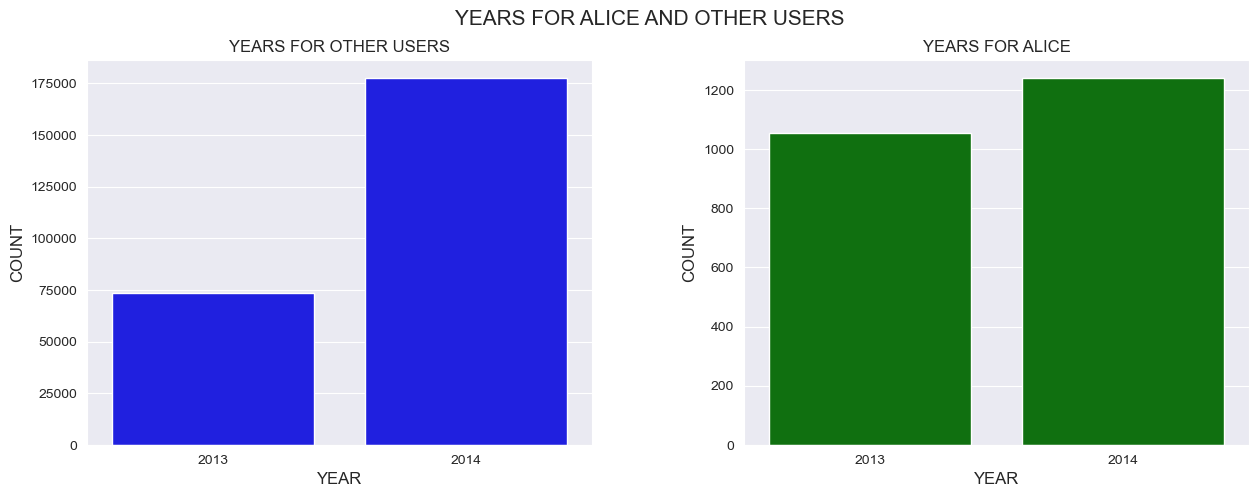

In [68]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('YEARS FOR ALICE AND OTHER USERS', fontsize=15)
position += 1
plt.subplot(1, 2, position)
plt.title('YEARS FOR OTHER USERS', fontsize=12)
sns.barplot(data=train.query('target == 0')['year'].value_counts().reset_index().rename(columns={'index':'years', 'year': 'count'}),
            x='years',
            y='count',
            color='b')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('YEAR', fontsize=12)
position += 1
plt.subplot(1, 2, position)
plt.title('YEARS FOR ALICE', fontsize=12)
sns.barplot(data=train.query('target == 1')['year'].value_counts().reset_index().rename(columns={'index':'years', 'year': 'count'}),
            x='years',
            y='count',
            color='g')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('YEAR', fontsize=12)
plt.show(True);

In [69]:
print('Unique year in Train: ', train['year'].unique())
print('\nUnique year in Test: ', test['year'].unique())

Unique year in Train:  [2013 2014]

Unique year in Test:  [2014]


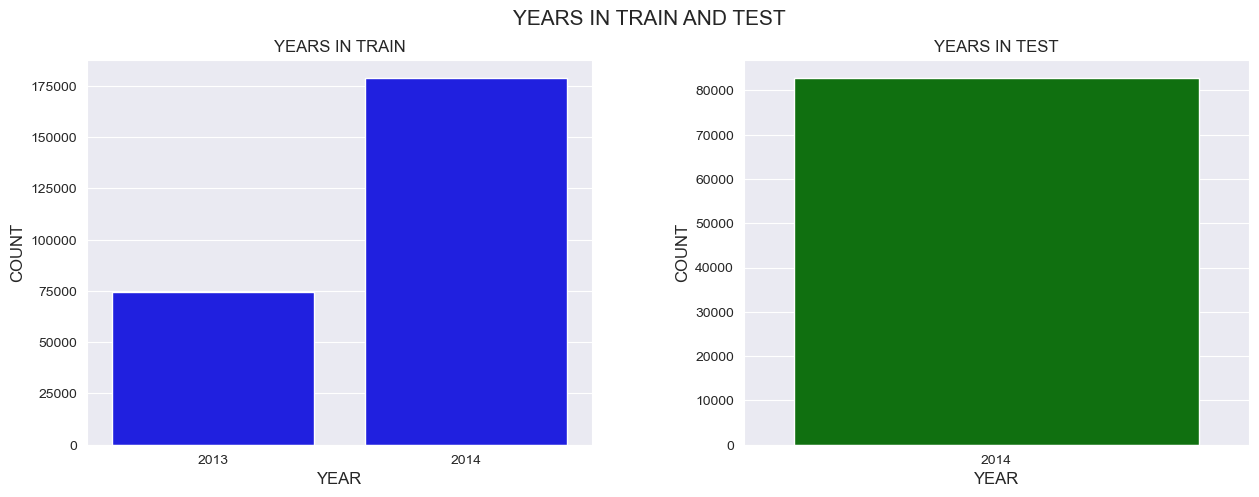

In [70]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('YEARS IN TRAIN AND TEST', fontsize=15)
position += 1
plt.subplot(1, 2, position)
plt.title('YEARS IN TRAIN', fontsize=12)
sns.barplot(data=train['year'].value_counts().reset_index().rename(columns={'index':'years', 'year': 'count'}),
            x='years',
            y='count',
            color='b')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('YEAR', fontsize=12)
position += 1
plt.subplot(1, 2, position)
plt.title('YEARS IN TEST', fontsize=12)
sns.barplot(data=test['year'].value_counts().reset_index().rename(columns={'index':'years', 'year': 'count'}),
            x='years',
            y='count',
            color='g')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('YEAR', fontsize=12)
plt.show(True);

### MONTHS

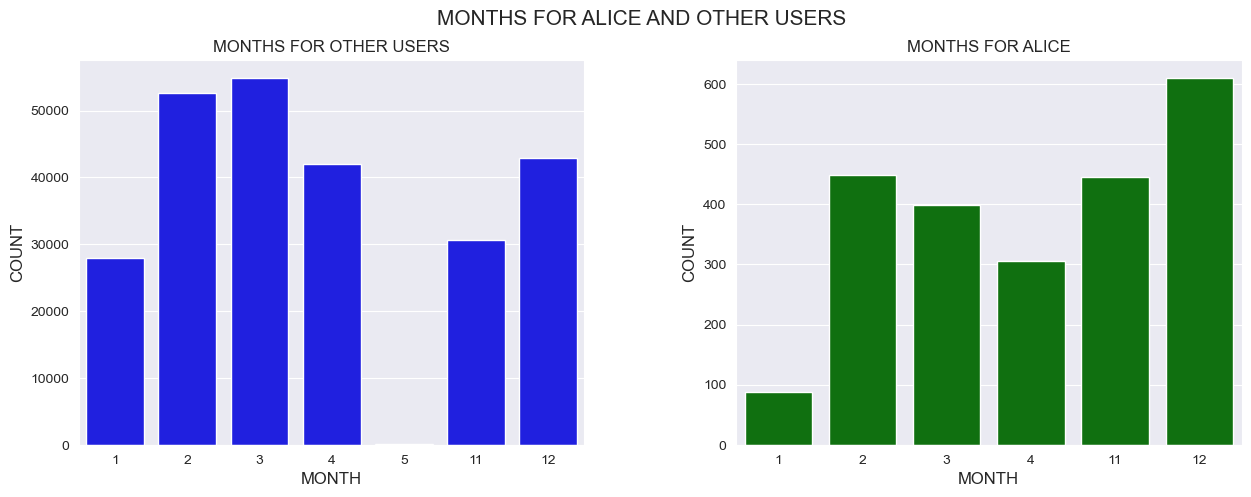

In [71]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('MONTHS FOR ALICE AND OTHER USERS', fontsize=15)
position += 1
plt.subplot(1, 2, position)
plt.title('MONTHS FOR OTHER USERS', fontsize=12)
sns.barplot(data=train.query('target == 0')['month'].value_counts().reset_index().rename(columns={'index':'months', 'month': 'count'}),
            x='months',
            y='count',
            color='b')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('MONTH', fontsize=12)
position += 1
plt.subplot(1, 2, position)
plt.title('MONTHS FOR ALICE', fontsize=12)
sns.barplot(data=train.query('target == 1')['month'].value_counts().reset_index().rename(columns={'index':'months', 'month': 'count'}),
            x='months',
            y='count',
            color='g')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('MONTH', fontsize=12)
plt.show(True);

In [72]:
print('Unique month in Train: ', sorted(train['month'].unique()))
print('\nUnique month in Test: ', sorted(test['month'].unique()))

Unique month in Train:  [1, 2, 3, 4, 5, 11, 12]

Unique month in Test:  [1, 2, 3, 4, 5]


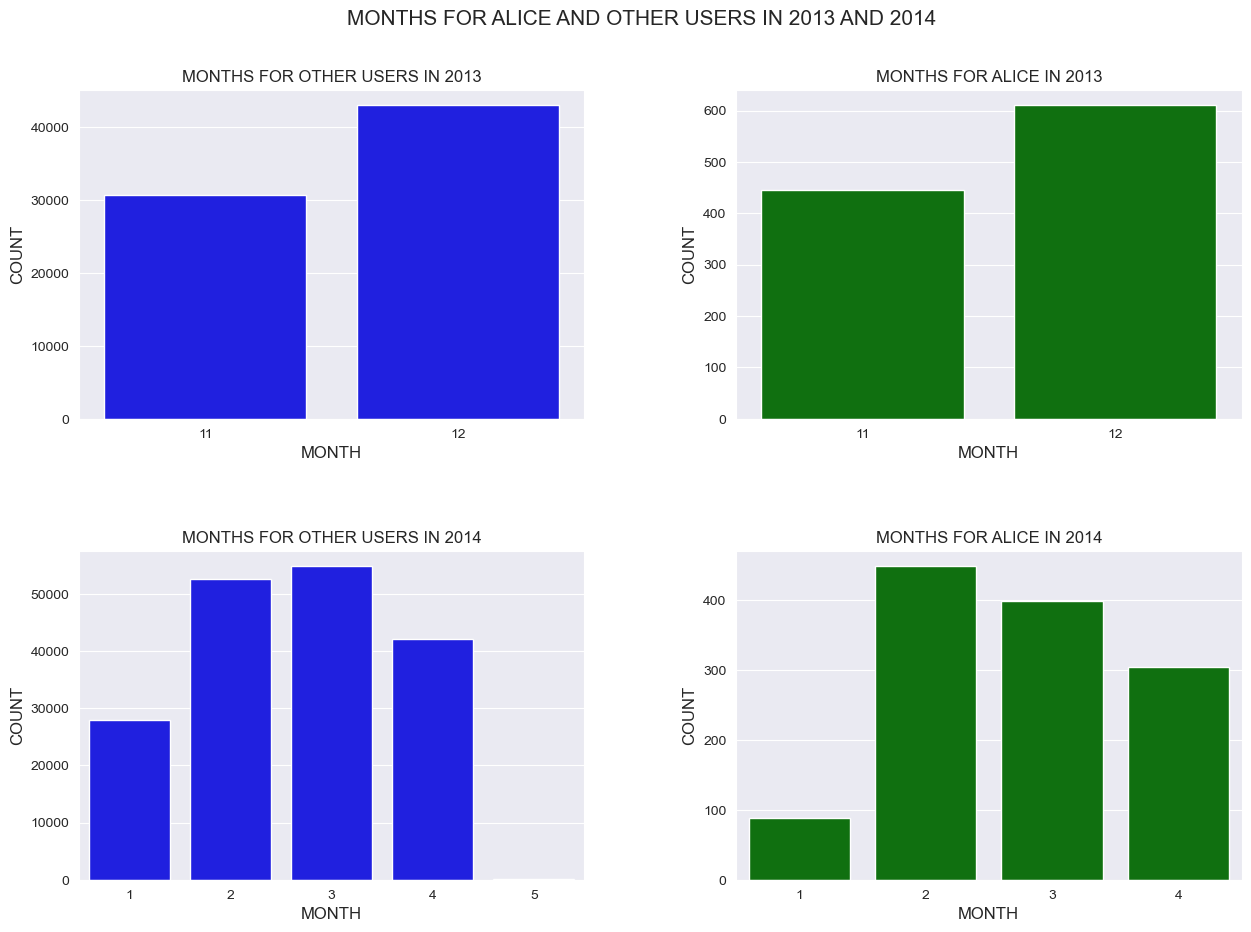

In [73]:
position = 0
plt.figure(figsize=[15, 10])
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.4)
sns.set_style('darkgrid')
plt.suptitle('MONTHS FOR ALICE AND OTHER USERS IN 2013 AND 2014', fontsize=15)
for year in [2013,2014]:
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'MONTHS FOR OTHER USERS IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 0) & (year==@year)')['month'].value_counts().reset_index().rename(columns={'index':'months', 'month': 'count'}),
                x='months',
                y='count',
                color='b')
    plt.ylabel('COUNT', fontsize=12)
    plt.xlabel('MONTH', fontsize=12)
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'MONTHS FOR ALICE IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 1) & (year==@year)')['month'].value_counts().reset_index().rename(columns={'index':'months', 'month': 'count'}),
                x='months',
                y='count',
                color='g')
    plt.ylabel('COUNT', fontsize=12)
    plt.xlabel('MONTH', fontsize=12)
plt.show(True);

### SESSION DURATION

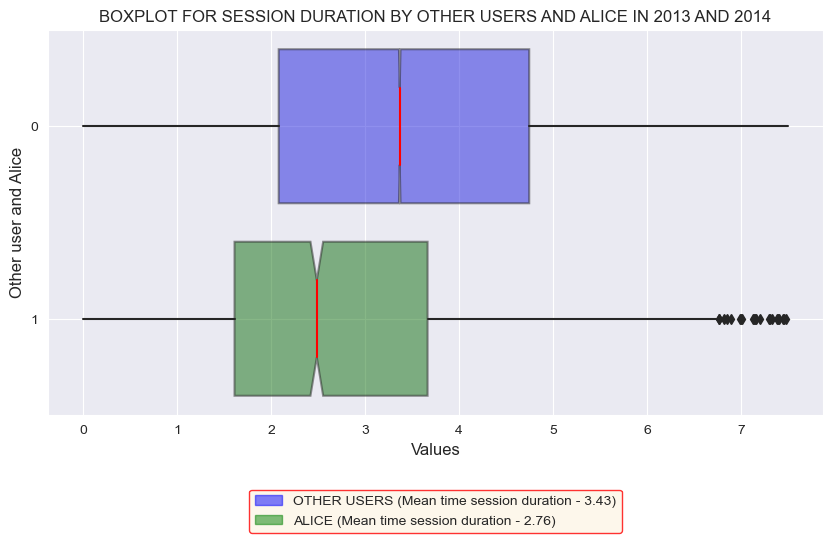

In [74]:
plt.figure(figsize=(10, 5))
plt.title('BOXPLOT FOR SESSION DURATION BY OTHER USERS AND ALICE IN 2013 AND 2014', fontsize=12)
ax = sns.boxplot(x='session_duration', y='target', data=train, order=[0,1], palette=['blue', 'green'],
            orient="h", showcaps=False, notch=True, medianprops={"color": "red"}, boxprops=dict(alpha=.5))
plt.ylabel('Other user and Alice', fontsize=12)
plt.xlabel('Values', fontsize=12)
plt.grid(True)
sns.set_style('darkgrid')
ses_dur_for_other_user = train.query('target == 0')['session_duration'].mean()
ses_der_for_alice = train.query('target == 1')['session_duration'].mean()
plt.legend(handles=[Patch(color='blue', alpha=.5, label=f'OTHER USERS (Mean time session duration - {ses_dur_for_other_user:.2f})'),
                    Patch(color='green', alpha=.5, label=f'ALICE (Mean time session duration - {ses_der_for_alice:.2f})')], 
           loc='center', 
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.25))
plt.show(True);

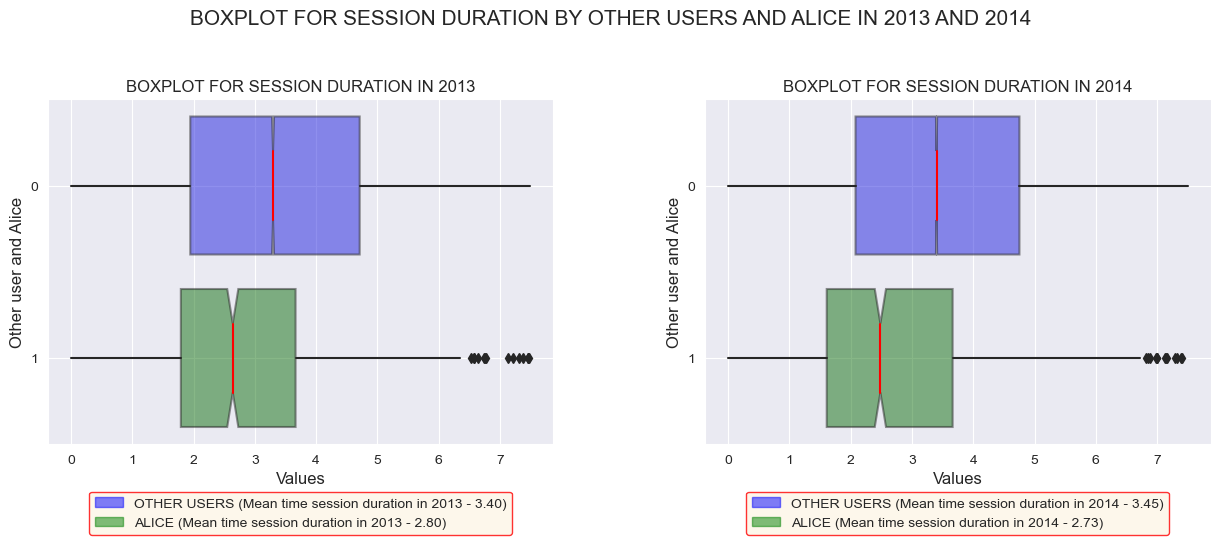

In [75]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.80, wspace=0.3, hspace=0.9)
plt.suptitle('BOXPLOT FOR SESSION DURATION BY OTHER USERS AND ALICE IN 2013 AND 2014', fontsize=15)
for year in [2013,2014]:
    position += 1
    plt.subplot(1, 2, position)
    plt.title(f'BOXPLOT FOR SESSION DURATION IN {year}', fontsize=12)
    ax = sns.boxplot(x='session_duration', y='target', data=train.query('year==@year'), order=[0,1], palette=['blue', 'green'],
                orient="h", showcaps=False, notch=True, medianprops={"color": "red"}, boxprops=dict(alpha=.5))
    plt.ylabel('Other user and Alice', fontsize=12)
    plt.xlabel('Values', fontsize=12)
    plt.grid(True)
    sns.set_style('darkgrid')
    ses_dur_for_other_user = train.query('(target == 0)&(year==@year)')['session_duration'].mean()
    ses_der_for_alice = train.query('(target == 1)&(year==@year)')['session_duration'].mean()
    plt.legend(handles=[Patch(color='blue', alpha=.5, label=f'OTHER USERS (Mean time session duration in {year} - {ses_dur_for_other_user:.2f})'),
                        Patch(color='green', alpha=.5, label=f'ALICE (Mean time session duration in {year} - {ses_der_for_alice:.2f})')], 
               loc='center', 
               edgecolor = 'r',
               facecolor = 'oldlace',
               bbox_to_anchor=(0.5, -0.2))
plt.show(True);

In [76]:
for df in [train, test]:
    df['short_session'] = df[sites].apply(lambda x:1 if ((~np.isin(x, ['empty'])).sum() < 10) else 0, axis=1)

In [77]:
train.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites,alices_sites_popularity_index,other_users_sites_popularity_index,any_sites_from_alices_sites,any_sites_from_users_sites,overall_sites_index_popularity,short_session
session_id,,,,,,,,,,,,,,,,,,,,,
21669,safebrowsing.clients.google.com,2013-12-01 08:05:57,safebrowsing-cache.google.com,2013-12-01 08:05:57,empty,NaT,empty,NaT,empty,NaT,...,0.0,0.0,3,2,0.014683,0.112457,0,1,2.948007,1
54843,safebrowsing.clients.google.com,2013-12-01 08:37:23,safebrowsing-cache.google.com,2013-12-01 08:37:23,safebrowsing.clients.google.com,2013-12-01 09:07:07,safebrowsing-cache.google.com,2013-12-01 09:07:09,empty,NaT,...,0.0,0.0,3,4,0.014683,0.112457,0,1,2.948007,1


In [78]:
test.head(2)

,site_1,time_1,site_2,time_2,site_3,time_3,site_4,time_4,site_5,time_5,...,time_for_site_8,time_for_site_9,number_of_unique_sites,number_of_sites,alices_sites_popularity_index,other_users_sites_popularity_index,any_sites_from_alices_sites,any_sites_from_users_sites,overall_sites_index_popularity,short_session
session_id,,,,,,,,,,,,,,,,,,,,,
1,www.facebook.com,2014-04-10 11:19:53,s-static.ak.facebook.com,2014-04-10 11:19:53,apis.google.com,2014-04-10 11:19:54,c1.adform.net,2014-04-10 11:19:54,www.google.com,2014-04-10 11:19:54,...,1.945910,0.000000,10,10,0.0,0.000028,0,1,0.000721,0
2,annotathon.org,2014-03-07 11:00:28,annotathon.org,2014-03-07 11:00:53,annotathon.org,2014-03-07 11:00:58,annotathon.org,2014-03-07 11:01:06,annotathon.org,2014-03-07 11:01:09,...,0.693147,3.178054,1,10,0.0,0.070762,0,1,1.851954,0


In [79]:
del df

### NUMBER OF UNIQUE SITES

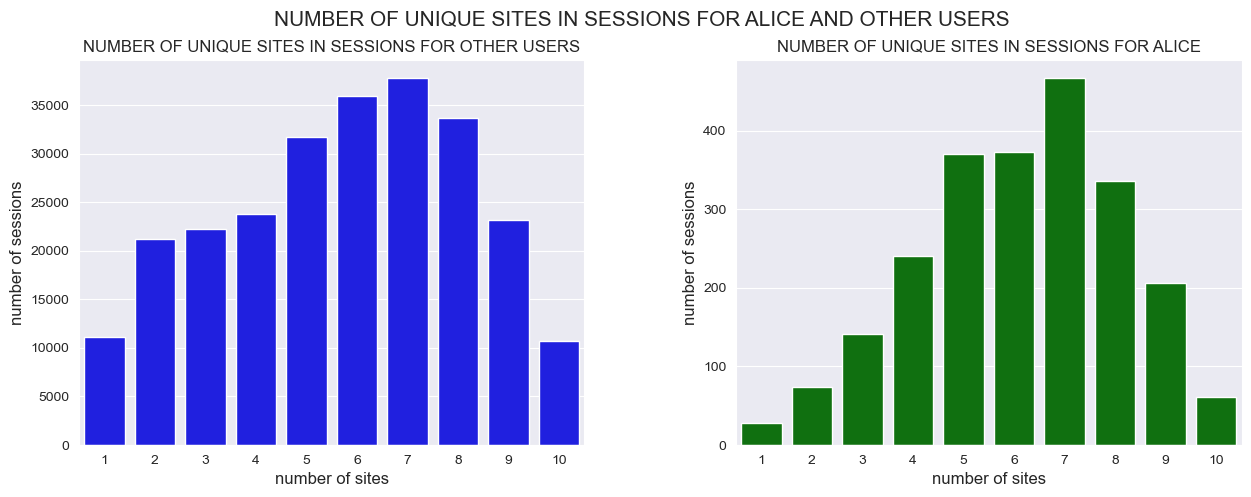

In [80]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('NUMBER OF UNIQUE SITES IN SESSIONS FOR ALICE AND OTHER USERS', fontsize=15)
position += 1
plt.subplot(1, 2, position)
plt.title('NUMBER OF UNIQUE SITES IN SESSIONS FOR OTHER USERS', fontsize=12)
sns.barplot(data=train.query('(target == 0)')['number_of_unique_sites'].value_counts().reset_index().rename(columns={'index':'number of unique sites', 'number_of_unique_sites': 'number sessions'}),
            x='number of unique sites',
            y='number sessions',
            color='b')
plt.ylabel('number of sessions', fontsize=12)
plt.xlabel('number of sites', fontsize=12)
position += 1
plt.subplot(1, 2, position)
plt.title('NUMBER OF UNIQUE SITES IN SESSIONS FOR ALICE', fontsize=12)
sns.barplot(data=train.query('(target == 1)')['number_of_unique_sites'].value_counts().reset_index().rename(columns={'index':'number of unique sites', 'number_of_unique_sites': 'number sessions'}),
            x='number of unique sites',
            y='number sessions',
            color='g')
plt.ylabel('number of sessions', fontsize=12)
plt.xlabel('number of sites', fontsize=12)
plt.show(True);

In [81]:
print('Unique sites in Train: ', sorted(train['number_of_unique_sites'].unique()))
print('\nUnique sites in Test: ', sorted(test['number_of_unique_sites'].unique()))

Unique sites in Train:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Unique sites in Test:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


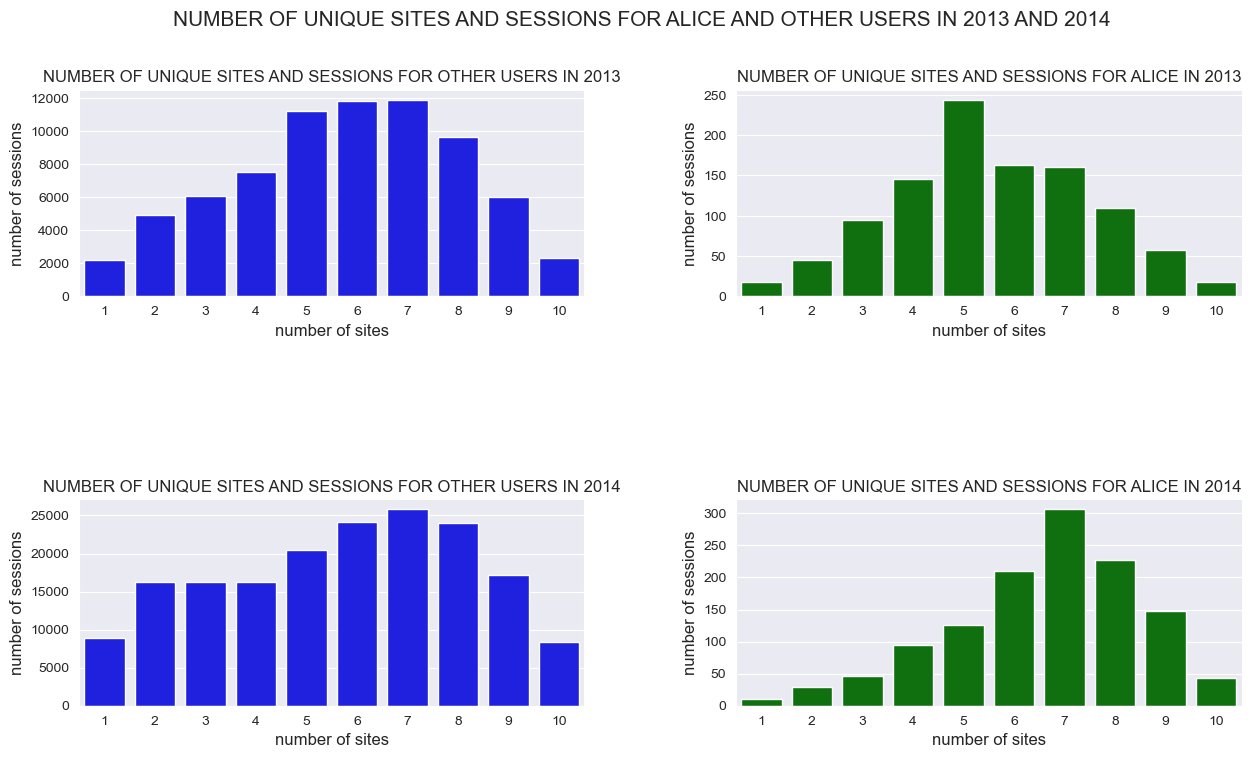

In [82]:
position = 0
plt.figure(figsize=[15, 8])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('NUMBER OF UNIQUE SITES AND SESSIONS FOR ALICE AND OTHER USERS IN 2013 AND 2014', fontsize=15)
for year in [2013,2014]:
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'NUMBER OF UNIQUE SITES AND SESSIONS FOR OTHER USERS IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 0) & (year == @year)')['number_of_unique_sites'].value_counts().reset_index().rename(columns={'index':'number of unique sites', 'number_of_unique_sites': 'number sessions'}),
                x='number of unique sites',
                y='number sessions',
                color='b')
    plt.ylabel('number of sessions', fontsize=12)
    plt.xlabel('number of sites', fontsize=12)
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'NUMBER OF UNIQUE SITES AND SESSIONS FOR ALICE IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 1) & (year==@year)')['number_of_unique_sites'].value_counts().reset_index().rename(columns={'index':'number of unique sites', 'number_of_unique_sites': 'number sessions'}),
                x='number of unique sites',
                y='number sessions',
                color='g')
    plt.ylabel('number of sessions', fontsize=12)
    plt.xlabel('number of sites', fontsize=12)
plt.show(True);

### DAYS OF MONTH

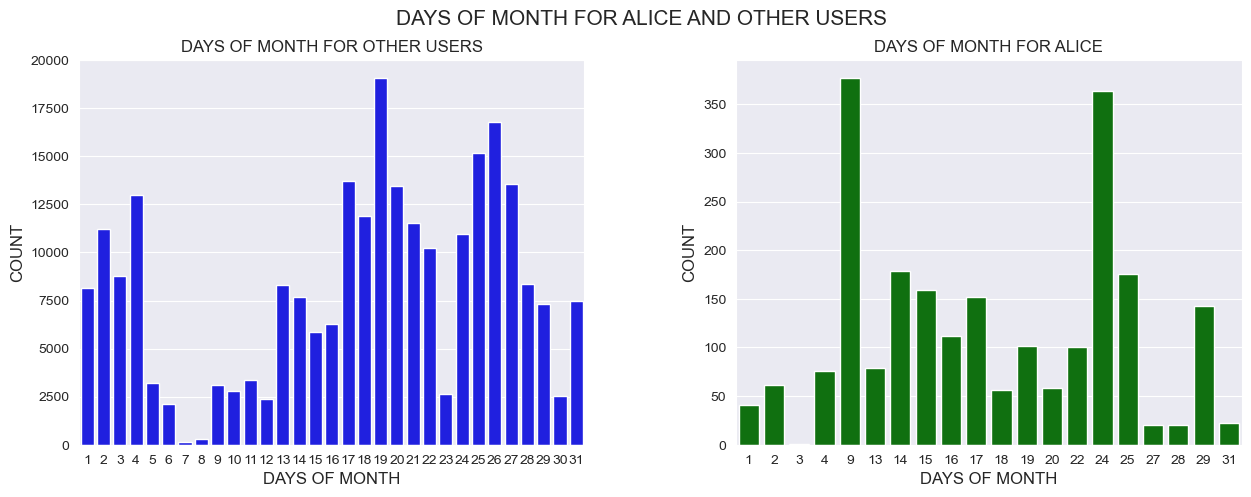

In [83]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('DAYS OF MONTH FOR ALICE AND OTHER USERS', fontsize=15)
position += 1
plt.subplot(1, 2, position)
plt.title('DAYS OF MONTH FOR OTHER USERS', fontsize=12)
sns.barplot(data=train.query('target == 0')['day_of_month'].value_counts().reset_index().rename(columns={'index':'day_of_month', 'day_of_month': 'count'}),
            x='day_of_month',
            y='count',
            color='b')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('DAYS OF MONTH', fontsize=12)
position += 1
plt.subplot(1, 2, position)
plt.title('DAYS OF MONTH FOR ALICE', fontsize=12)
sns.barplot(data=train.query('target == 1')['day_of_month'].value_counts().reset_index().rename(columns={'index':'day_of_month', 'day_of_month': 'count'}),
            x='day_of_month',
            y='count',
            color='g')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('DAYS OF MONTH', fontsize=12)
plt.show(True);

In [84]:
print('Unique days of month in Train: ', sorted(train['day_of_month'].unique()))
print('\nUnique days of month in Test: ', sorted(test['day_of_month'].unique()))

Unique days of month in Train:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

Unique days of month in Test:  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


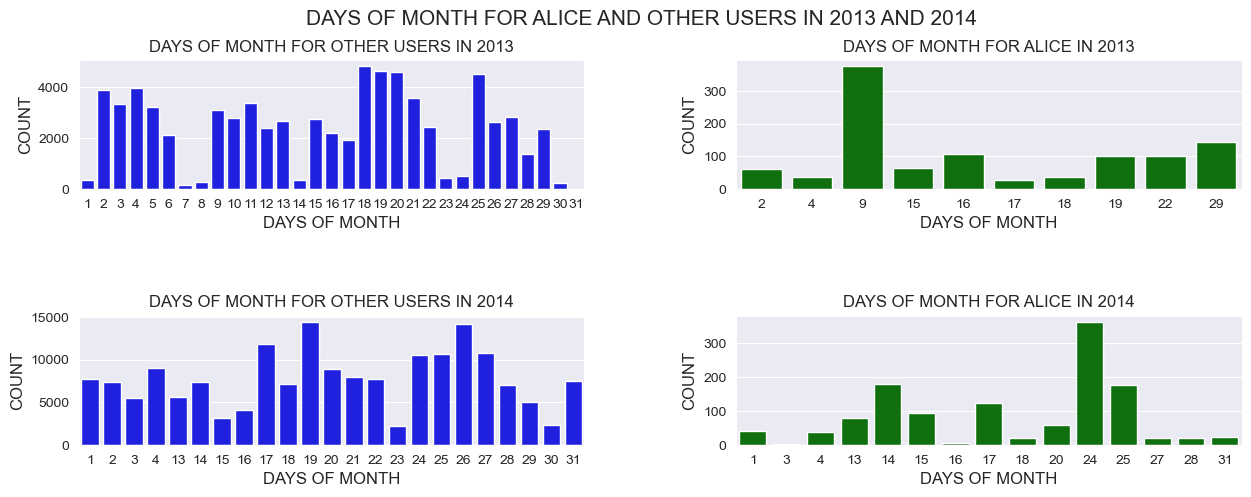

In [85]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('DAYS OF MONTH FOR ALICE AND OTHER USERS IN 2013 AND 2014', fontsize=15)
for year in [2013,2014]:
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'DAYS OF MONTH FOR OTHER USERS IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 0) & (year==@year)')['day_of_month'].value_counts().reset_index().rename(columns={'index':'day_of_month', 'day_of_month': 'count'}),
                x='day_of_month',
                y='count',
                color='b')
    plt.ylabel('COUNT', fontsize=12)
    plt.xlabel('DAYS OF MONTH', fontsize=12)
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'DAYS OF MONTH FOR ALICE IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 1) & (year==@year)')['day_of_month'].value_counts().reset_index().rename(columns={'index':'day_of_month', 'day_of_month': 'count'}),
                x='day_of_month',
                y='count',
                color='g')
    plt.ylabel('COUNT', fontsize=12)
    plt.xlabel('DAYS OF MONTH', fontsize=12)
plt.show(True);

### DAYS OF WEEK

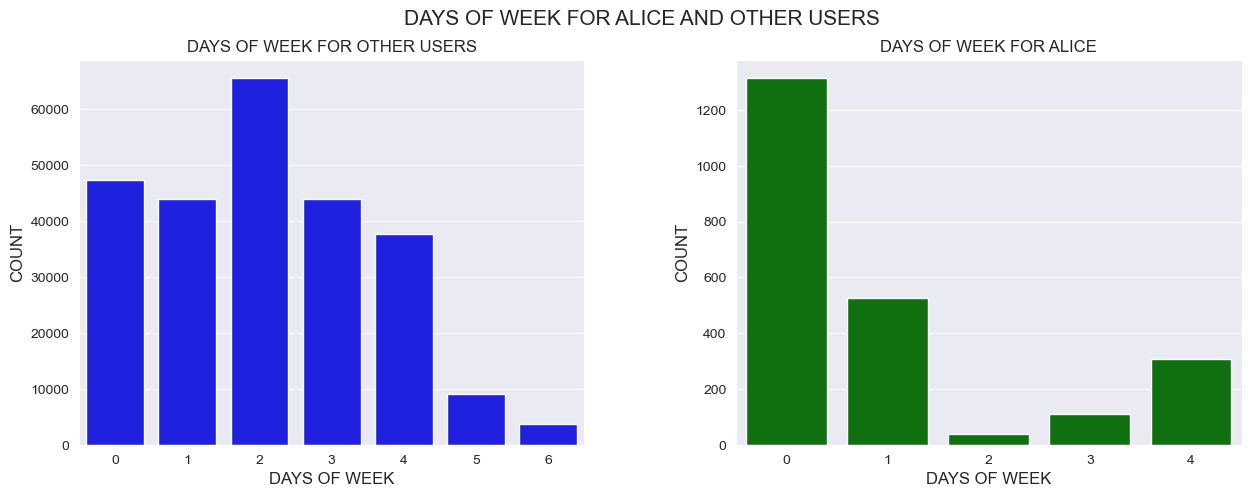

In [86]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('DAYS OF WEEK FOR ALICE AND OTHER USERS', fontsize=15)
position += 1
plt.subplot(1, 2, position)
plt.title('DAYS OF WEEK FOR OTHER USERS', fontsize=12)
sns.barplot(data=train.query('target == 0')['day_of_week'].value_counts().reset_index().rename(columns={'index':'days_of_week', 'day_of_week': 'count'}),
            x='days_of_week',
            y='count',
            color='b')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('DAYS OF WEEK', fontsize=12)
position += 1
plt.subplot(1, 2, position)
plt.title('DAYS OF WEEK FOR ALICE', fontsize=12)
sns.barplot(data=train.query('target == 1')['day_of_week'].value_counts().reset_index().rename(columns={'index':'days_of_week', 'day_of_week': 'count'}),
            x='days_of_week',
            y='count',
            color='g')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('DAYS OF WEEK', fontsize=12)
plt.show(True);

In [87]:
print('Unique days of week in Train: ', sorted(train['day_of_week'].unique()))
print('\nUnique days of week in Test: ', sorted(test['day_of_week'].unique()))

Unique days of week in Train:  [0, 1, 2, 3, 4, 5, 6]

Unique days of week in Test:  [0, 1, 2, 3, 4, 5, 6]


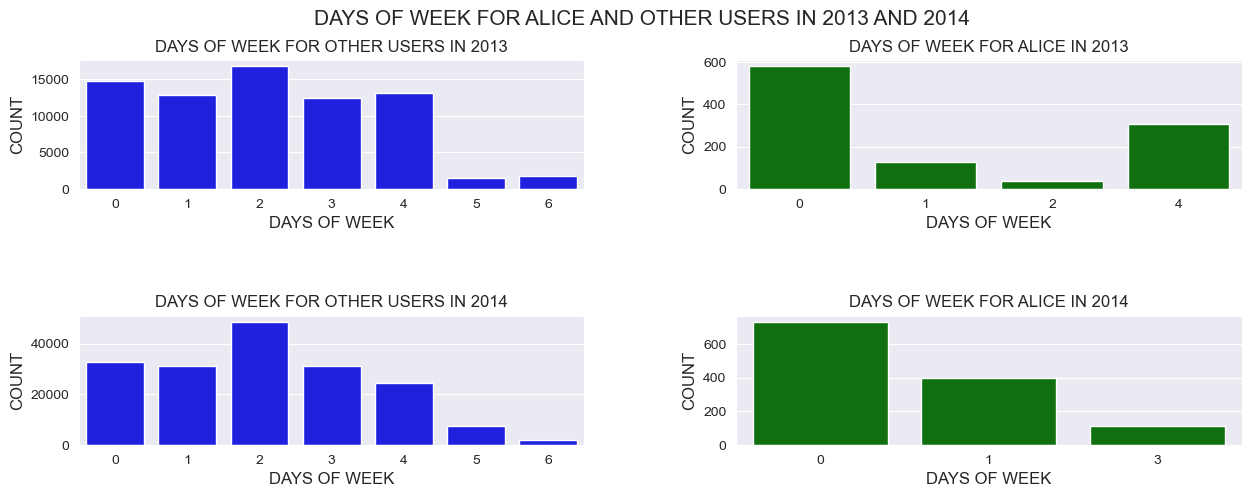

In [88]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('DAYS OF WEEK FOR ALICE AND OTHER USERS IN 2013 AND 2014', fontsize=15)
for year in [2013,2014]:
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'DAYS OF WEEK FOR OTHER USERS IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 0) & (year==@year)')['day_of_week'].value_counts().reset_index().rename(columns={'index':'days_of_week', 'day_of_week': 'count'}),
                x='days_of_week',
                y='count',
                color='b')
    plt.ylabel('COUNT', fontsize=12)
    plt.xlabel('DAYS OF WEEK', fontsize=12)
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'DAYS OF WEEK FOR ALICE IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 1) & (year==@year)')['day_of_week'].value_counts().reset_index().rename(columns={'index':'days_of_week', 'day_of_week': 'count'}),
                x='days_of_week',
                y='count',
                color='g')
    plt.ylabel('COUNT', fontsize=12)
    plt.xlabel('DAYS OF WEEK', fontsize=12)
plt.show(True);

In [89]:
train = pd.get_dummies(train, columns=['day_of_week'])
test = pd.get_dummies(test, columns=['day_of_week'])

### SESSIONS START HOUR

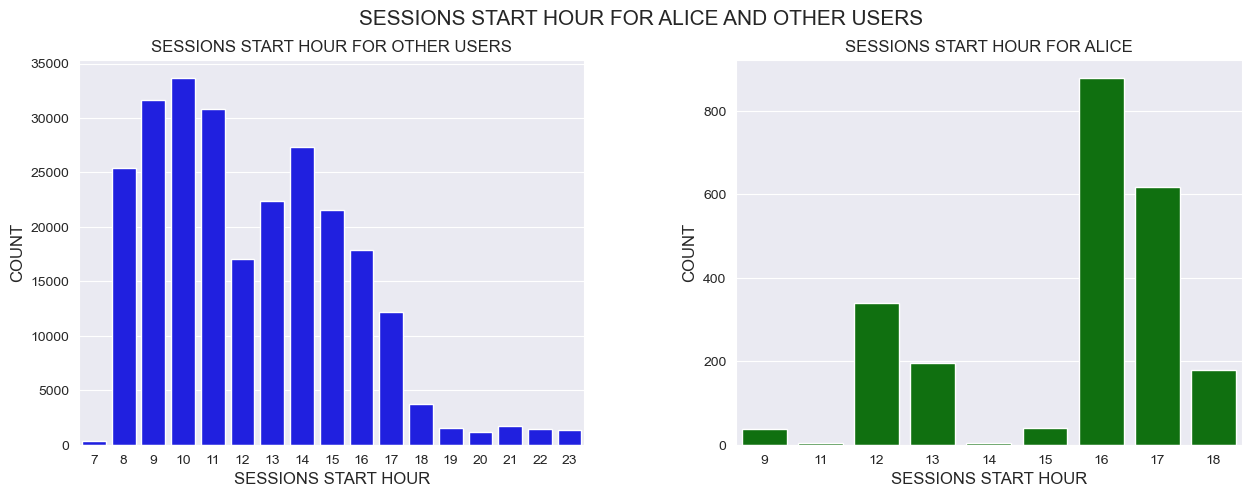

In [90]:
position = 0
plt.figure(figsize=[15, 5])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('SESSIONS START HOUR FOR ALICE AND OTHER USERS', fontsize=15)
position += 1
plt.subplot(1, 2, position)
plt.title('SESSIONS START HOUR FOR OTHER USERS', fontsize=12)
sns.barplot(data=train.query('target == 0')['start_session'].value_counts().reset_index().rename(columns={'index':'start_session', 'start_session': 'count'}),
            x='start_session',
            y='count',
            color='b')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('SESSIONS START HOUR', fontsize=12)
position += 1
plt.subplot(1, 2, position)
plt.title('SESSIONS START HOUR FOR ALICE', fontsize=12)
sns.barplot(data=train.query('target == 1')['start_session'].value_counts().reset_index().rename(columns={'index':'start_session', 'start_session': 'count'}),
            x='start_session',
            y='count',
            color='g')
plt.ylabel('COUNT', fontsize=12)
plt.xlabel('SESSIONS START HOUR', fontsize=12)
plt.show(True);

In [91]:
print('Unique value of sessions start hour in Train: ', sorted(train['start_session'].unique()))
print('\nUnique value of sessions start hour in Test: ', sorted(test['start_session'].unique()))

Unique value of sessions start hour in Train:  [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

Unique value of sessions start hour in Test:  [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


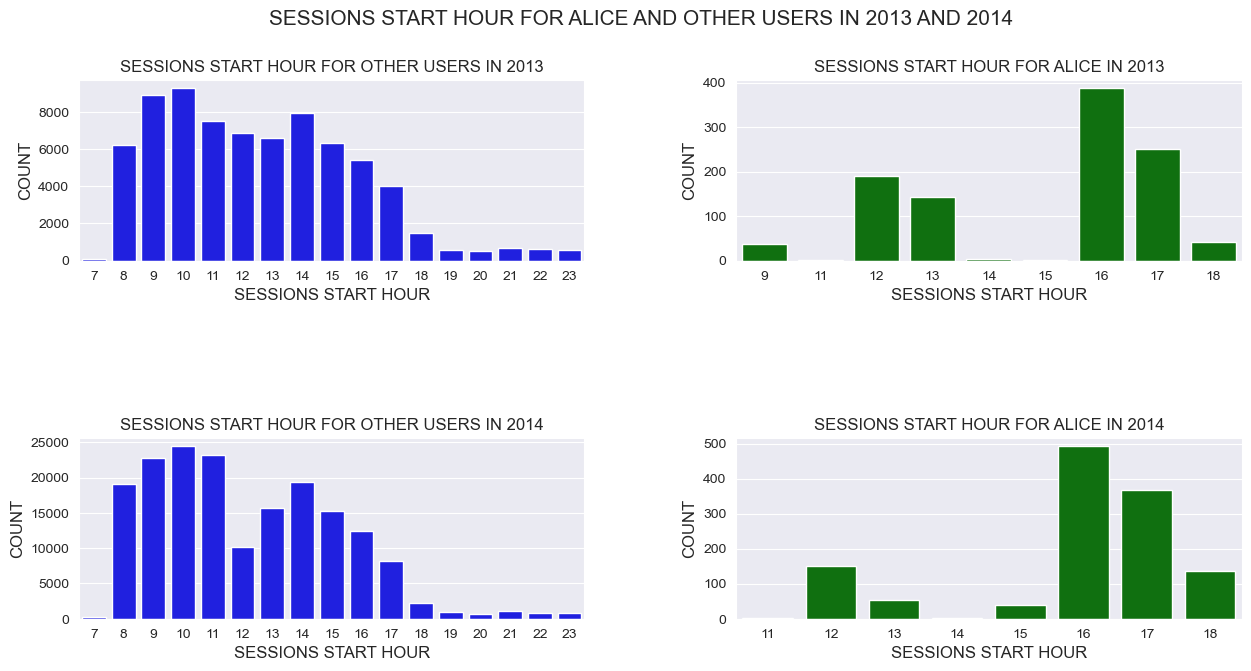

In [92]:
position = 0
plt.figure(figsize=[15, 7])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('SESSIONS START HOUR FOR ALICE AND OTHER USERS IN 2013 AND 2014', fontsize=15)
for year in [2013,2014]:
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'SESSIONS START HOUR FOR OTHER USERS IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 0) & (year==@year)')['start_session'].value_counts().reset_index().rename(columns={'index':'start_session', 'start_session': 'count'}),
                x='start_session',
                y='count',
                color='b')
    plt.ylabel('COUNT', fontsize=12)
    plt.xlabel('SESSIONS START HOUR', fontsize=12)
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'SESSIONS START HOUR FOR ALICE IN {year}', fontsize=12)
    sns.barplot(data=train.query('(target == 1) & (year==@year)')['start_session'].value_counts().reset_index().rename(columns={'index':'start_session', 'start_session': 'count'}),
                x='start_session',
                y='count',
                color='g')
    plt.ylabel('COUNT', fontsize=12)
    plt.xlabel('SESSIONS START HOUR', fontsize=12)
plt.show(True);

In [93]:
train = pd.get_dummies(train, columns=['start_session'], drop_first=False)
test = pd.get_dummies(test, columns=['start_session'], drop_first=False)

# TARGET ATRIBUTE BALANCE

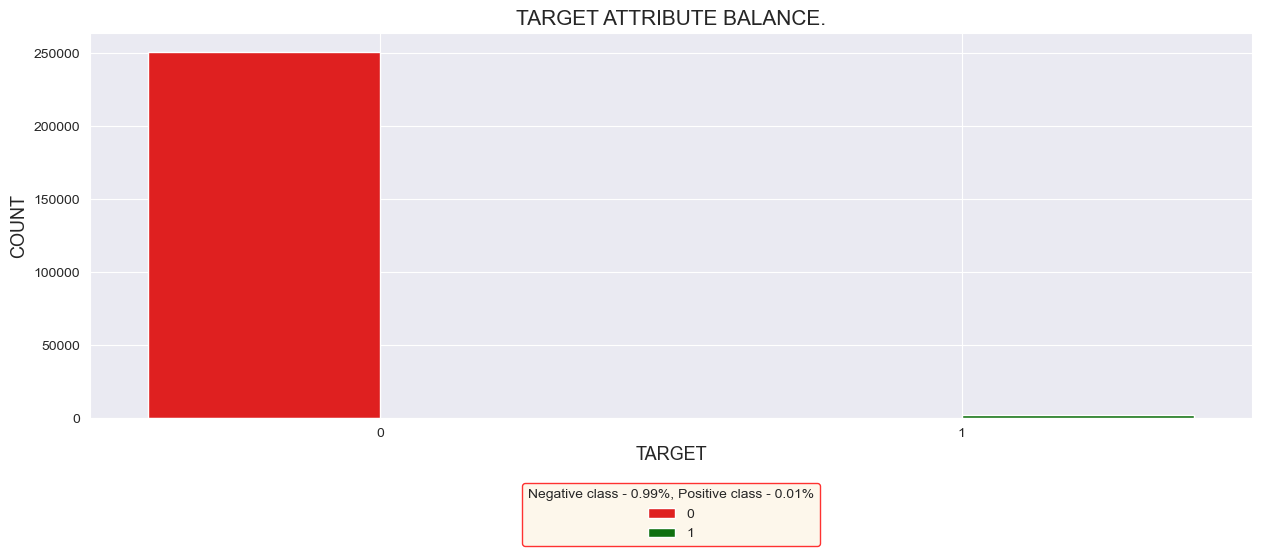

In [94]:
plt.figure(figsize=[15, 5])
plt.title('TARGET ATTRIBUTE BALANCE.', fontsize=15)
sns.set_style('darkgrid')
sns.barplot(data=train['target'].value_counts().reset_index().rename(columns={'index':'target', 'target': 'count'}),
            x='target',
            y='count',
            hue='target',
            palette=['red', 'green'])
plt.ylabel('COUNT', fontsize=13)
plt.xlabel('TARGET', fontsize=13)
plt.grid(True)
negative_class = train['target'].value_counts(normalize=True)[0]
positive_class = train['target'].value_counts(normalize=True)[1]
plt.legend(title=f'Negative class - {negative_class:.2f}%, Positive class - {positive_class:.2f}%',
           loc='center', 
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.25))
plt.show();

# CORRELATION

In [95]:
train_for_matrix = train.drop(times, axis=1)
train_for_matrix.drop(sites, axis=1, inplace=True)

In [96]:
train_for_matrix.columns

Index(['target', 'month', 'year', 'day_of_month', 'month_year',
       'session_duration', 'morning', 'day', 'evening', 'night',
       'time_for_site_1', 'time_for_site_2', 'time_for_site_3',
       'time_for_site_4', 'time_for_site_5', 'time_for_site_6',
       'time_for_site_7', 'time_for_site_8', 'time_for_site_9',
       'number_of_unique_sites', 'number_of_sites',
       'alices_sites_popularity_index', 'other_users_sites_popularity_index',
       'any_sites_from_alices_sites', 'any_sites_from_users_sites',
       'overall_sites_index_popularity', 'short_session', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'start_session_7', 'start_session_8',
       'start_session_9', 'start_session_10', 'start_session_11',
       'start_session_12', 'start_session_13', 'start_session_14',
       'start_session_15', 'start_session_16', 'start_session_17',
       'start_session_18', 'start_session_19', 'star

In [97]:
scaler = StandardScaler()
for column in train_for_matrix.drop('target', axis=1).columns.tolist():
    train_for_matrix[column] = scaler.fit_transform(train_for_matrix[column].values.reshape(-1, 1))

In [98]:
train_for_matrix.head()

,target,month,year,day_of_month,month_year,session_duration,morning,day,evening,night,...,start_session_14,start_session_15,start_session_16,start_session_17,start_session_18,start_session_19,start_session_20,start_session_21,start_session_22,start_session_23
session_id,,,,,,,,,,,,,,,,,,,,,
21669,0,1.611863,-1.547745,-1.943496,-1.53735,-1.908139,1.039131,-0.98134,-0.171586,0.0,...,-0.3474,-0.305466,-0.282499,-0.230873,-0.124959,-0.078175,-0.068961,-0.082283,-0.076288,-0.072866
54843,0,1.611863,-1.547745,-1.943496,-1.53735,2.260930,1.039131,-0.98134,-0.171586,0.0,...,-0.3474,-0.305466,-0.282499,-0.230873,-0.124959,-0.078175,-0.068961,-0.082283,-0.076288,-0.072866
77292,0,1.611863,-1.547745,-1.943496,-1.53735,-1.012092,1.039131,-0.98134,-0.171586,0.0,...,-0.3474,-0.305466,-0.282499,-0.230873,-0.124959,-0.078175,-0.068961,-0.082283,-0.076288,-0.072866
114021,0,1.611863,-1.547745,-1.943496,-1.53735,-1.136326,1.039131,-0.98134,-0.171586,0.0,...,-0.3474,-0.305466,-0.282499,-0.230873,-0.124959,-0.078175,-0.068961,-0.082283,-0.076288,-0.072866
146670,0,1.611863,-1.547745,-1.943496,-1.53735,-1.296492,1.039131,-0.98134,-0.171586,0.0,...,-0.3474,-0.305466,-0.282499,-0.230873,-0.124959,-0.078175,-0.068961,-0.082283,-0.076288,-0.072866


In [99]:
del scaler, column

## PEARSON CORRELATION COEFFICIENT

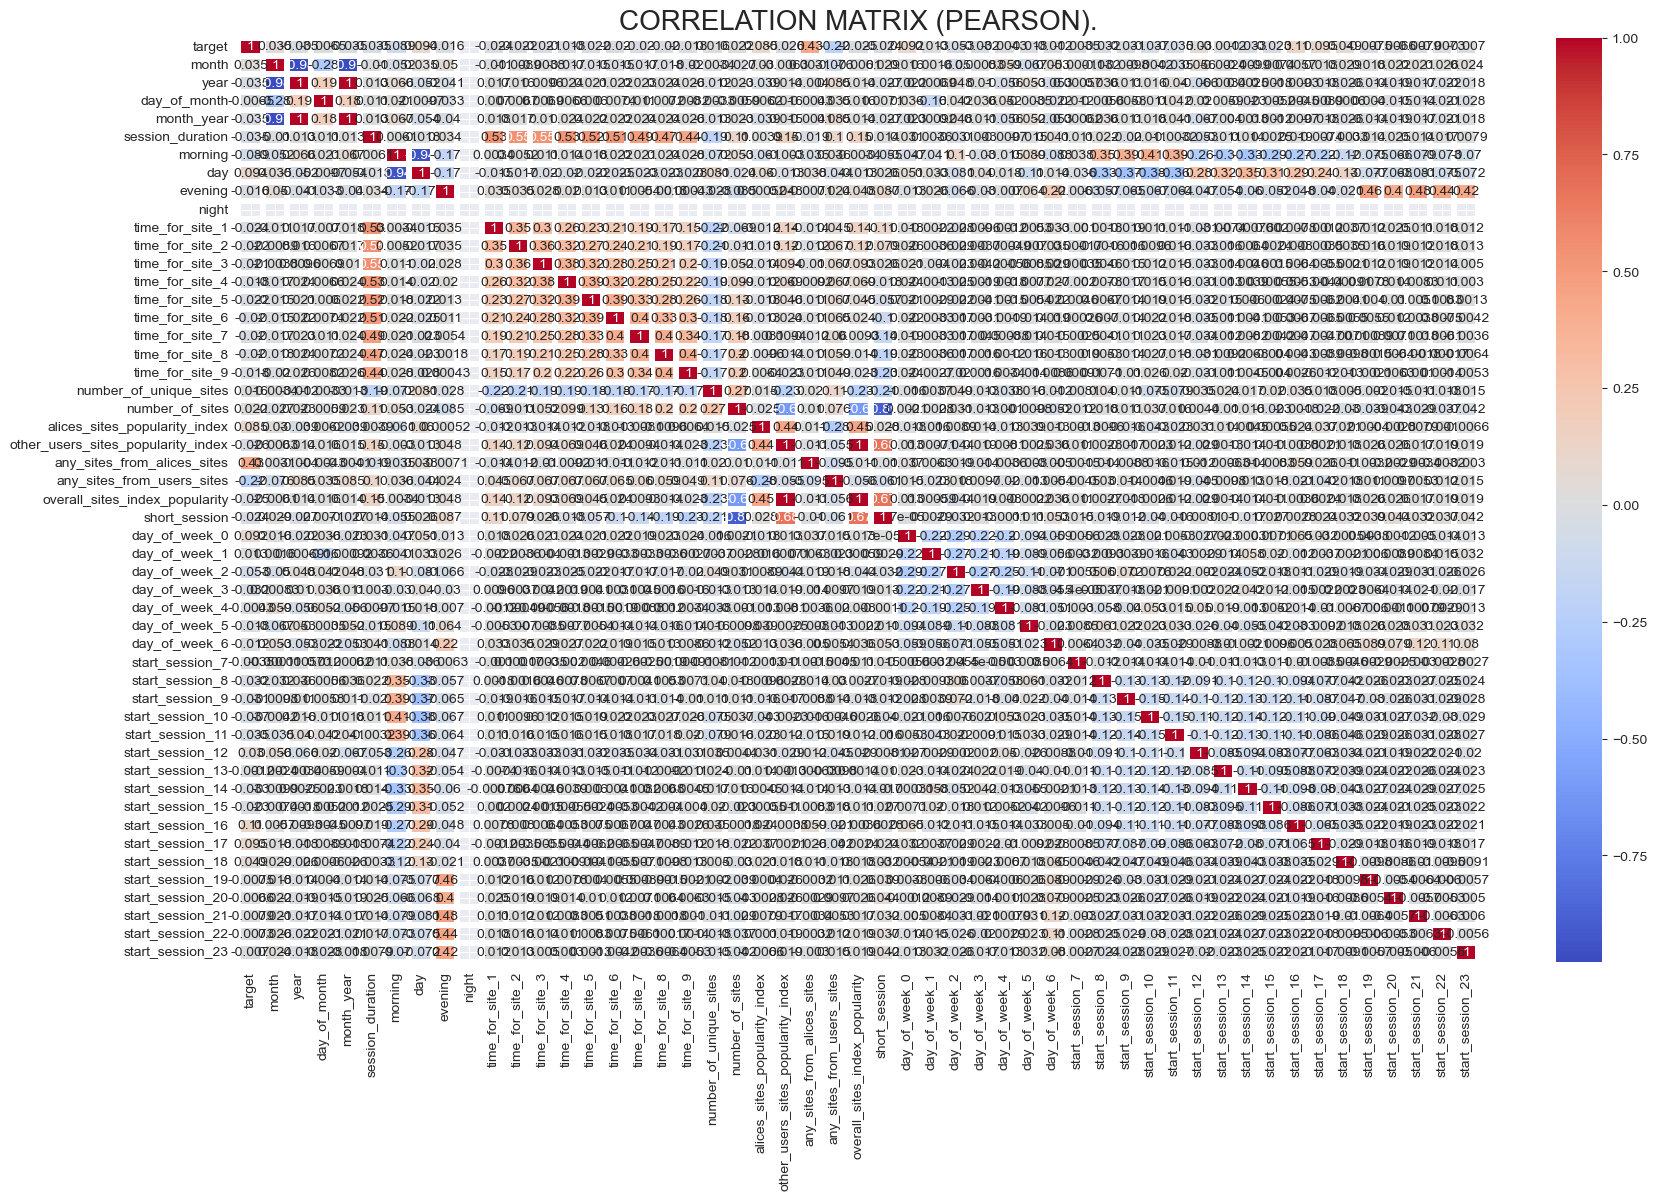

In [100]:
fig, ax = plt.subplots(figsize=(20,12))
plt.title('CORRELATION MATRIX (PEARSON).', fontsize=20)
sns.heatmap(train_for_matrix.corr(), annot=True, cmap="coolwarm",  fmt='.2g', linewidth=4)
plt.grid(True);

In [101]:
train_for_matrix.drop(['month','year', 'night', 'morning', 'day', 'evening', 'number_of_sites',
                       'time_for_site_1', 'time_for_site_2', 'time_for_site_3', 'time_for_site_4',
                       'time_for_site_5', 'time_for_site_6', 'time_for_site_7',
                       'time_for_site_8', 'time_for_site_9'], axis=1, inplace=True)

## POINT-BISERIAL CORRELATION

In [102]:
correlations_point_biserial = []
for column in train_for_matrix.drop('target', axis=1).columns:
    correlations_point_biserial.append(stats.pointbiserialr(train_for_matrix[column], train_for_matrix['target'])[0])
df_with_point_biserial_corr = pd.DataFrame({'column': train_for_matrix.drop('target', axis=1).columns.tolist(),
                                            'correlation point biserial': correlations_point_biserial}) \
                                            .set_index('column')

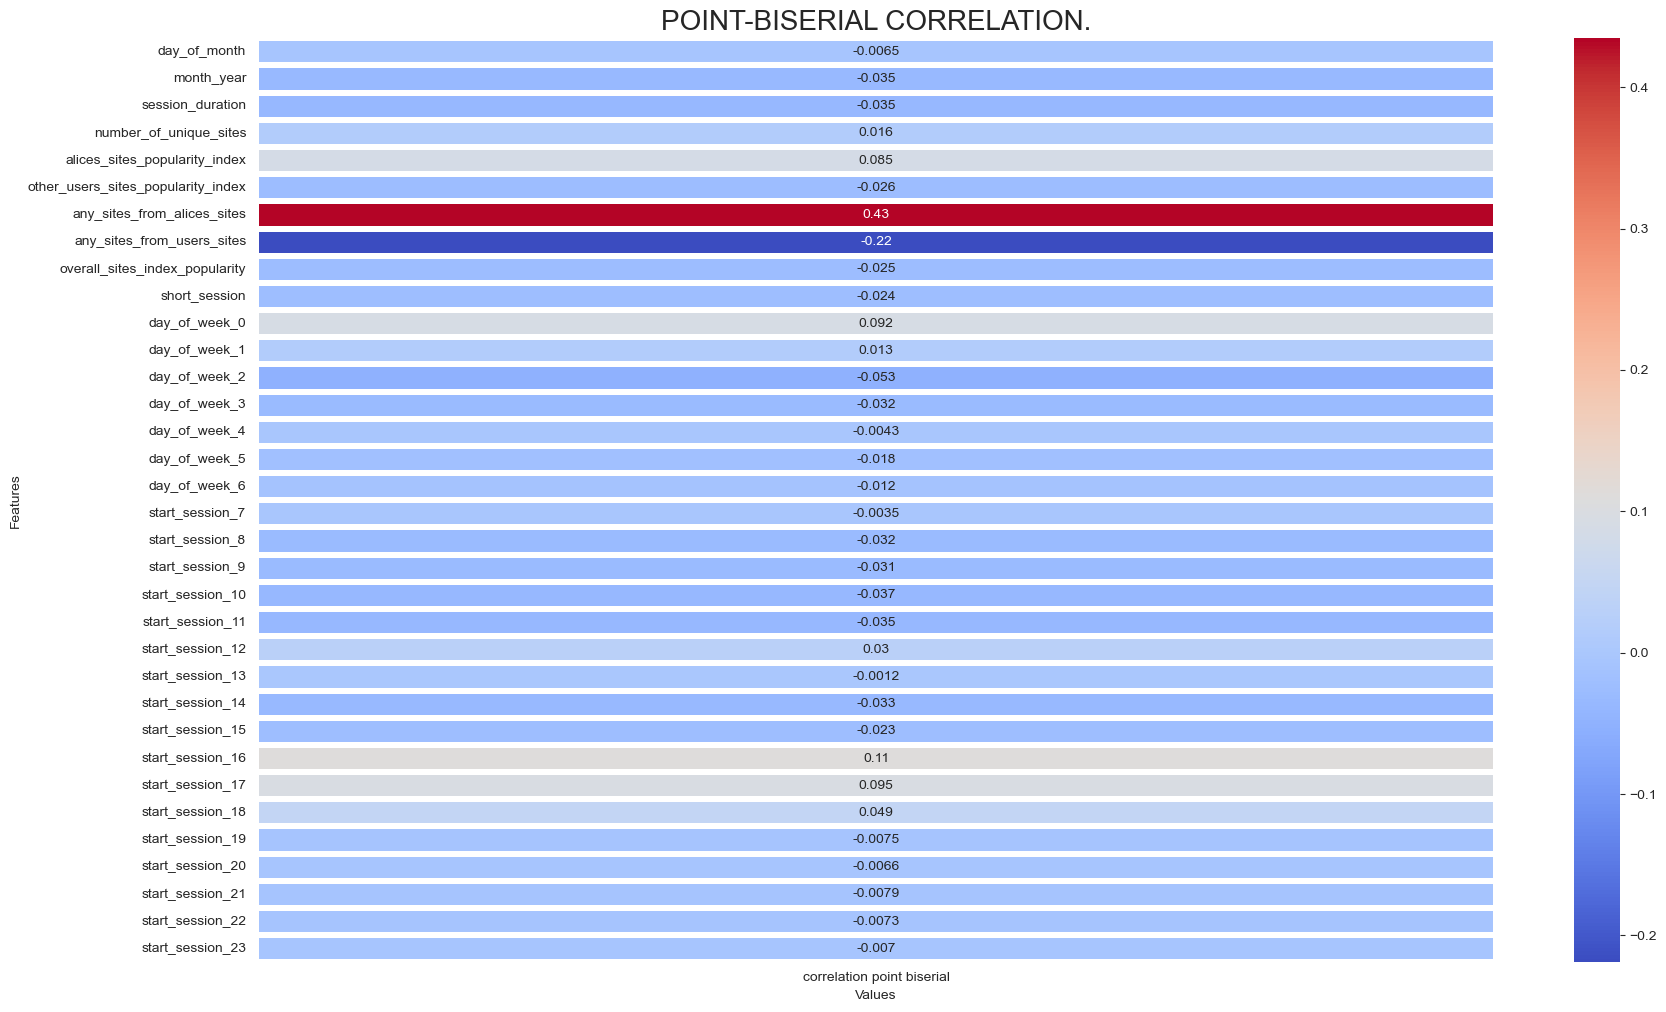

In [103]:
fig, ax = plt.subplots(figsize=(20,12))
plt.title('POINT-BISERIAL CORRELATION.', fontsize=20)
sns.heatmap(df_with_point_biserial_corr,
            annot=True,
            cmap="coolwarm",
            fmt='.2g',
            linewidth=4)
plt.ylabel('Features')
plt.xlabel('Values')
plt.grid(True)

In [104]:
del correlations_point_biserial, df_with_point_biserial_corr

# BEST FEATURES

## SELECT K BEST

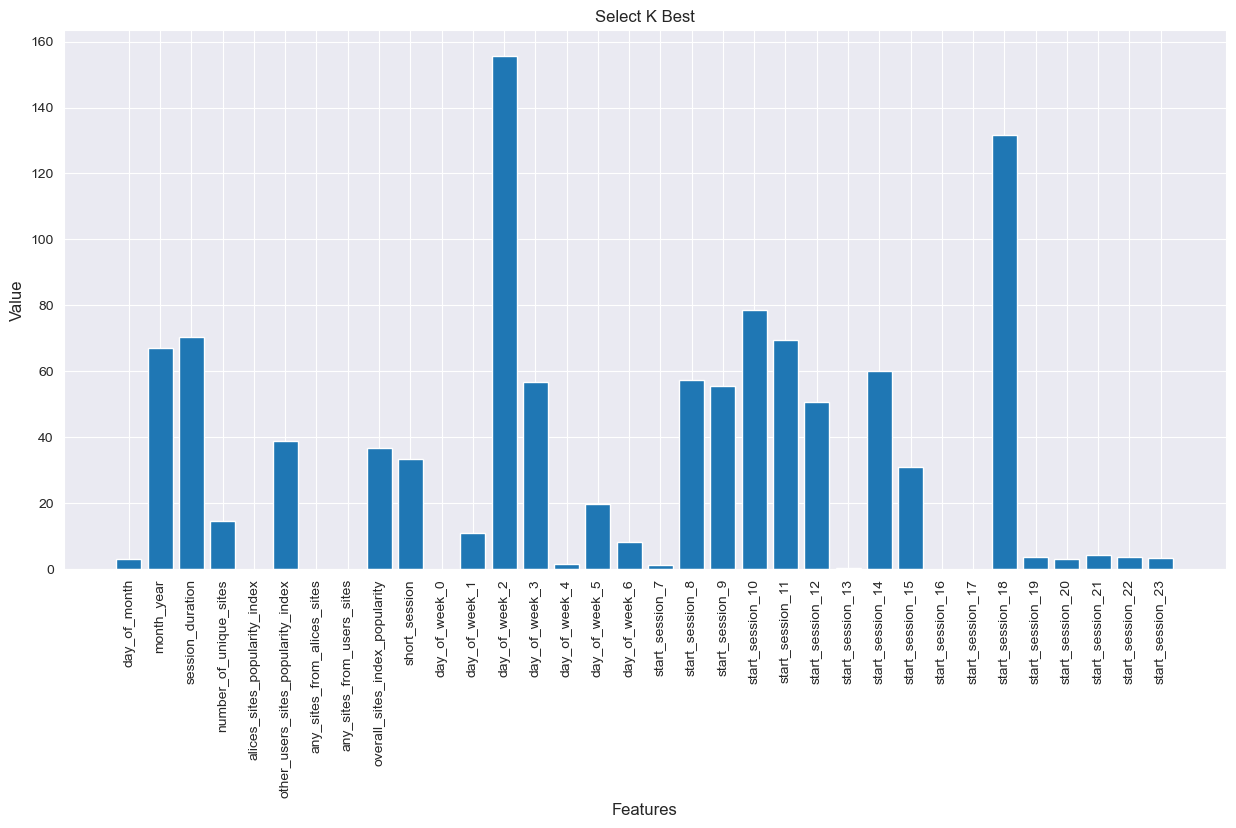

In [105]:
plt.figure(figsize=(15, 7))
plt.title('Select K Best', fontsize=12)
selector = SelectKBest(f_classif, k='all')
selector.fit(train_for_matrix[train_for_matrix.drop('target', axis=1).columns.to_list()],
             train_for_matrix["target"])
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(train_for_matrix.drop('target', axis=1).columns.to_list())), scores)
plt.xticks(range(len(train_for_matrix.drop('target', axis=1).columns.to_list())),
           train_for_matrix.drop('target', axis=1).columns.to_list(),
           rotation='vertical')
plt.ylabel('Value', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.grid(True)
sns.set_style('darkgrid')
plt.show(True);

In [106]:
train_for_matrix.drop(['day_of_month', 'alices_sites_popularity_index', 'other_users_sites_popularity_index',
                       'number_of_unique_sites', 'short_session',
                       'any_sites_from_alices_sites','any_sites_from_users_sites'], axis=1, inplace=True)

### RFE, SELECT FROM MODEL, SEQUENTIALFEATURESELECTOR

In [107]:
target = train_for_matrix["target"]
features = train_for_matrix.drop('target', axis=1)

In [108]:
model = LogisticRegression(random_state=42)
model.fit(features, target)

LogisticRegression(random_state=42)

In [109]:
selector = SelectFromModel(estimator=LogisticRegression(random_state=42))
selector.fit(train_for_matrix.drop('target', axis=1), train_for_matrix["target"])

SelectFromModel(estimator=LogisticRegression(random_state=42))

In [110]:
rfe = RFE(estimator=LogisticRegression(random_state=42, solver='liblinear'))
rfe = rfe.fit(train_for_matrix.drop('target', axis=1), train_for_matrix["target"])

In [111]:
sfs = SequentialFeatureSelector(estimator=LogisticRegression(random_state=42, solver='liblinear'),
                                k_features='best',
                                scoring='roc_auc',
                               n_jobs=-1)
sfs = sfs.fit(features, target)

In [112]:
pd.DataFrame(data={'Features': train_for_matrix.drop('target', axis=1).columns,
                   'Ranking by RFE': rfe.ranking_,
                   'Support by RFE': rfe.support_,
                   'Support by Select from model': selector.get_support(),
                   'Support by Sequential Feature Selector': np.isin(features.columns, sfs.k_feature_names_),
                   'Coefficient by Select from model': selector.estimator_.coef_.flatten(),
                   'Coefficient by model': model.coef_.flatten()})

,Features,Ranking by RFE,Support by RFE,Support by Select from model,Support by Sequential Feature Selector,Coefficient by Select from model,Coefficient by model
0,month_year,6,False,False,True,-0.296468,-0.296468
1,session_duration,4,False,False,True,-0.392364,-0.392364
2,overall_sites_index_popularity,5,False,False,True,-0.332888,-0.332888
3,day_of_week_0,1,True,True,True,0.772201,0.772201
4,day_of_week_1,1,True,False,False,0.532729,0.532729
5,day_of_week_2,1,True,True,True,-0.763887,-0.763887
6,day_of_week_3,14,False,False,False,-0.093530,-0.093530
7,day_of_week_4,2,False,False,False,0.302477,0.302477
8,day_of_week_5,1,True,True,True,-0.893969,-0.893969
9,day_of_week_6,1,True,True,True,-0.658928,-0.658928


In [113]:
print(f"Number of selected features by RFE - {len(rfe.get_feature_names_out())}")
print(f"Number of selected features by Select from model - {len(train_for_matrix.drop('target', axis=1).columns[selector.get_support()])}")
print(f"Number of selected features by Sequential Feature Selector - {len(sfs.k_feature_names_)}")

Number of selected features by RFE - 13
Number of selected features by Select from model - 12
Number of selected features by Sequential Feature Selector - 21


In [114]:
train_for_matrix.drop(['overall_sites_index_popularity',
                       'start_session_13', 'start_session_16', 'start_session_17'], axis=1, inplace=True)

In [115]:
logit_model=sm.Logit(train_for_matrix["target"],train_for_matrix.drop('target', axis=1)[train_for_matrix.drop('target', axis=1).columns.tolist()])
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.692584
         Iterations: 35


/Users/greygreywolf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               Results: Logit
Model:                  Logit               Pseudo R-squared:    -12.413    
Dependent Variable:     target              AIC:                 351231.7628
Date:                   2023-02-08 15:55    BIC:                 351471.9576
No. Observations:       253533              Log-Likelihood:      -1.7559e+05
Df Model:               22                  LL-Null:             -13091.    
Df Residuals:           253510              LLR p-value:         1.0000     
Converged:              0.0000              Scale:               1.0000     
No. Iterations:         35.0000                                             
----------------------------------------------------------------------------
                  Coef.    Std.Err.     z    P>|z|     [0.025       0.975]  
----------------------------------------------------------------------------
month_year       -0.0091      0.0040 -2.2755 0.0229      -0.0170     -0.0013
session_duration -0.0133      

In [116]:
selected_features = train_for_matrix.drop('target', axis=1).columns.tolist()

In [117]:
del train_for_matrix, fig, ax, selector, scores, model, rfe, result, logit_model, sfs, features, target

# PREPARATION FOR TEST AND TRAINING

## BAG OF SITES (COUNT VECTORIZER)

In [118]:
for site in sites:
    print(f'\nNumber of unique sites in "{site}" for TRAIN - {len(train[site].unique())} and TEST - {len(test[site].unique())}')


Number of unique sites in "site_1" for TRAIN - 15765 and TEST - 6326

Number of unique sites in "site_2" for TRAIN - 15822 and TEST - 6208

Number of unique sites in "site_3" for TRAIN - 15760 and TEST - 6139

Number of unique sites in "site_4" for TRAIN - 15776 and TEST - 6209

Number of unique sites in "site_5" for TRAIN - 15841 and TEST - 6178

Number of unique sites in "site_6" for TRAIN - 15769 and TEST - 6116

Number of unique sites in "site_7" for TRAIN - 15773 and TEST - 6194

Number of unique sites in "site_8" for TRAIN - 15855 and TEST - 6113

Number of unique sites in "site_9" for TRAIN - 15725 and TEST - 6212

Number of unique sites in "site_10" for TRAIN - 15676 and TEST - 6111


In [119]:
print('UNIQUE NUMBER SITES IN SESSION FOR TRAIN:')
train[sites].isin(['no_site']).sum(axis=1).apply(lambda x: 10 - x).value_counts().reset_index().rename(columns={'index': 'NUMBER OF SITES IN SESSION',
                                                                                                       0: 'NUMBER IN DATASET'}).sort_values(by='NUMBER OF SITES IN SESSION')

UNIQUE NUMBER SITES IN SESSION FOR TRAIN:


,NUMBER OF SITES IN SESSION,NUMBER IN DATASET
0,10,253533


In [120]:
print('UNIQUE NUMBER SITES IN SESSION FOR TEST:')
test[sites].isin(['no_site']).sum(axis=1).apply(lambda x: 10 - x).value_counts().reset_index().rename(columns={'index': 'NUMBER OF SITES IN SESSION',
                                                                                                       0: 'NUMBER IN DATASET'}).sort_values(by='NUMBER OF SITES IN SESSION')

UNIQUE NUMBER SITES IN SESSION FOR TEST:


,NUMBER OF SITES IN SESSION,NUMBER IN DATASET
0,10,82797


In [121]:
vect = TfidfVectorizer(ngram_range=(1,5), 
                       tokenizer=lambda s: s.split(), 
                       max_features=50000)

In [122]:
train_site_matrix = train[sites].astype('str').to_numpy().tolist()
train_site_matrix = [' '.join(sublist) for sublist in train_site_matrix]
train_site_matrix = vect.fit_transform(train_site_matrix)

In [123]:
print('TRAIN SITE MATRIX')
pd.DataFrame(data = train_site_matrix.toarray(), columns = vect.get_feature_names()).T.head(3)

TRAIN SITE MATRIX


,0,1,2,3,4,5,6,7,8,9,...,253523,253524,253525,253526,253527,253528,253529,253530,253531,253532
0.academia-assets.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.docs.google.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.docs.google.com 0.docs.google.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
test_site_matrix = test[sites].astype('str').to_numpy().tolist()
test_site_matrix = [' '.join(sublist) for sublist in test_site_matrix]
test_site_matrix = vect.transform(test_site_matrix)

In [125]:
print('TEST SITE MATRIX')
pd.DataFrame(data = test_site_matrix.toarray(), columns = vect.get_feature_names()).T.head(3)

TEST SITE MATRIX


,0,1,2,3,4,5,6,7,8,9,...,82787,82788,82789,82790,82791,82792,82793,82794,82795,82796
0.academia-assets.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.docs.google.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.docs.google.com 0.docs.google.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SITES FEATURES

In [126]:
print('Columns with features')
print()
print((selected_features))

Columns with features

['month_year', 'session_duration', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'start_session_7', 'start_session_8', 'start_session_9', 'start_session_10', 'start_session_11', 'start_session_12', 'start_session_14', 'start_session_15', 'start_session_18', 'start_session_19', 'start_session_20', 'start_session_21', 'start_session_22', 'start_session_23']


In [127]:
train_site_features = train[selected_features]
test_site_features = test[selected_features]

In [128]:
scaler = StandardScaler()
for column in selected_features:
    train_site_features[column] = scaler.fit_transform(train_site_features[column].values.reshape(-1, 1))
    test_site_features[column] = scaler.transform(test_site_features[column].values.reshape(-1, 1))

In [129]:
del selected_features, scaler

## MAKE FULL DF FOR TRAIN AND TEST

In [130]:
updated_train = csr_matrix(hstack([train_site_matrix, train_site_features.values]))
updated_test = csr_matrix(hstack([test_site_matrix, test_site_features.values]))

In [131]:
print('\nTRAIN SHAPE -',updated_train.shape)
print('\nTEST SHAPE -',updated_test.shape)


TRAIN SHAPE - (253533, 50023)

TEST SHAPE - (82797, 50023)


In [132]:
del train_site_features, test_site_features, train_site_matrix, test_site_matrix, vect

## TRAIN AND TEST DF

In [133]:
target = train['target']
x_train, x_test, y_train, y_test = train_test_split(updated_train, target, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [134]:
print(f'SIZE TRAIN FEATURES - {x_train.shape}, SIZE TEST FEATURES - {x_test.shape}')
print(f'\nSIZE TRAIN TARGET - {y_train.shape}, SIZE TEST TARGET - {y_test.shape}')

SIZE TRAIN FEATURES - (202826, 50023), SIZE TEST FEATURES - (50707, 50023)

SIZE TRAIN TARGET - (202826,), SIZE TEST TARGET - (50707,)


In [135]:
del train, test, dictionary_of_sites

# FIND BEST MODEL

In [136]:
dct_with_models = {}

In [138]:
%%time
splits = TimeSeriesSplit(n_splits=10)
for label_model, model in { 'LR': [LogisticRegression(random_state=42)],
                            'SGD': [SGDClassifier(random_state=42, loss='log')]}.items():
    
    scores = cross_val_score(model[0], updated_train, target, cv=splits, scoring='roc_auc')
    dct_with_models[f'{label_model}_overall_roc_auc_for_model_for_dataset'] = np.mean(scores) 

CPU times: user 1min 51s, sys: 2.57 s, total: 1min 53s
Wall time: 30.5 s


In [139]:
model = []
overall_roc_auc_for_dataset = []

for name_model in ['LR', 'SGD']:
    model.append(name_model)
    overall_roc_auc_for_dataset.append(dct_with_models[f'{name_model}_overall_roc_auc_for_model_for_dataset'])

In [140]:
results = {
    'Model' : model,
    'OVERALL ROC_AUC FOR TRAIN DATASET' : pd.Series(overall_roc_auc_for_dataset)}

display(pd.DataFrame(results).style.highlight_min(color='red',axis=0).highlight_max(color='lightblue',axis=0))

,Model,OVERALL ROC_AUC FOR TRAIN DATASET
0,LR,0.910110
1,SGD,0.884629


In [141]:
model = LogisticRegression(random_state=42)
model.fit(x_train,y_train)
pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)),
            columns=['Not Alice', 'Alice'],
            index = ['Actual 0', 'Actual 1'])

,Not Alice,Alice
Actual 0,50247,18
Actual 1,303,139


In [142]:
model

LogisticRegression(random_state=42)

# FIND BEST PARAMS FOR MODEL

In [143]:
%%time
param = {'C': np.logspace(-1,1,20).tolist()}
grid = GridSearchCV(LogisticRegression(random_state=42), param, cv=splits, scoring='roc_auc')
grid.fit(updated_train, target)
dct_with_models['LR_overall_roc_auc_for_model_for_dataset_with_best_params'] = grid.best_score_

CPU times: user 33min 59s, sys: 32.5 s, total: 34min 32s
Wall time: 8min 43s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 0.12742749857031338, 0.16237767391887217,
                               0.20691380811147897, 0.26366508987303583,
                               0.33598182862837817, 0.42813323987193935,
                               0.5455594781168519, 0.6951927961775606,
                               0.8858667904100825, 1.1288378916846888,
                               1.438449888287663, 1.8329807108324356,
                               2.3357214690901213, 2.9763514416313175,
                               3.79269019073225, 4.832930238571752,
                               6.158482110660261, 7.847599703514611, 10.0]},
             scoring='roc_auc')

In [144]:
grid_result = pd.DataFrame(grid.cv_results_)

In [145]:
grid_result[['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_C,mean_test_score,std_test_score,rank_test_score
0,0.1,0.888385,0.107324,20
1,0.127427,0.891588,0.105335,19
2,0.162378,0.894422,0.103632,18
3,0.206914,0.897113,0.102261,17
4,0.263665,0.899514,0.101202,16
5,0.335982,0.902669,0.100067,15
6,0.428133,0.904333,0.099639,14
7,0.545559,0.907269,0.098958,13
8,0.695193,0.908209,0.099416,12
9,0.885867,0.909330,0.099707,11


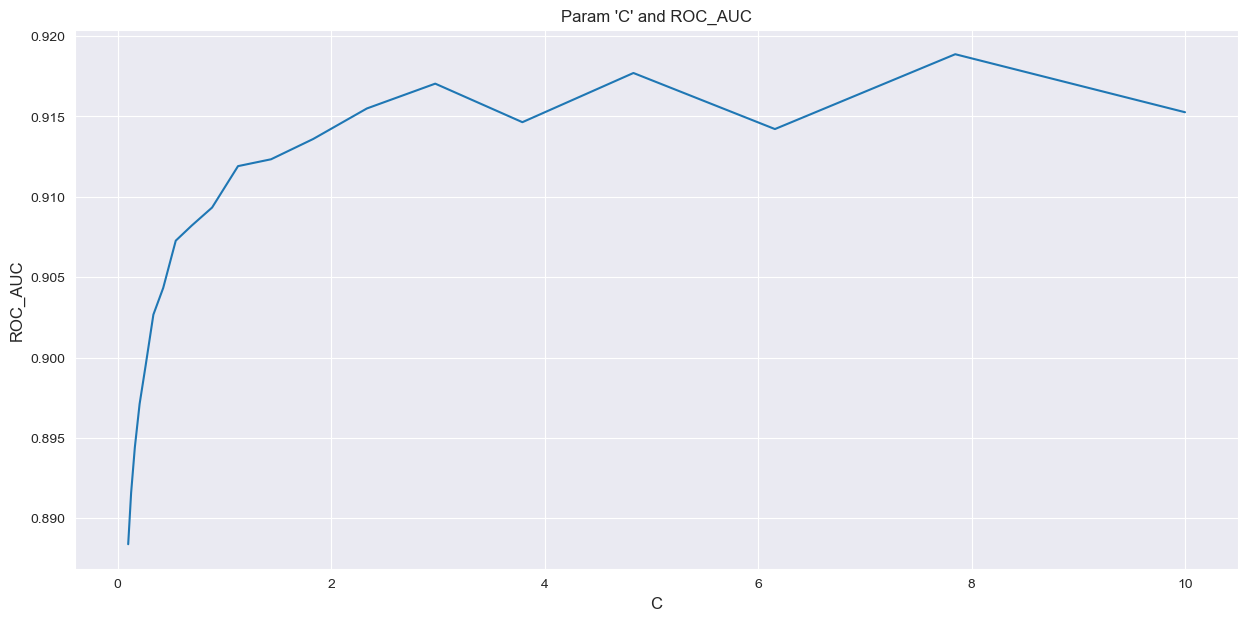

In [146]:
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
plt.title("Param 'C' and ROC_AUC", fontsize=12)
sns.lineplot(data=grid_result, x="param_C", y="mean_test_score")
plt.ylabel('ROC_AUC', fontsize=12)
plt.xlabel('C', fontsize=12)
plt.grid(True);

In [155]:
model = []
roc_auc_train_with_best_params = []
overall_roc_auc_for_dataset = []

for name_model in ['LR']:
    model.append(name_model)
    overall_roc_auc_for_dataset.append(dct_with_models[f'{name_model}_overall_roc_auc_for_model_for_dataset'])
    roc_auc_train_with_best_params.append(dct_with_models[f'{name_model}_overall_roc_auc_for_model_for_dataset_with_best_params'])

In [157]:
results = {
    'Model' : model,
    'OVERALL ROC_AUC FOR TRAIN DATASET' : pd.Series(overall_roc_auc_for_dataset),
    'OVERALL ROC_AUC FOR TRAIN WITH BEST PARAMS' : pd.Series(roc_auc_train_with_best_params)}

display(pd.DataFrame(results).style.highlight_max(color='green'))

,Model,OVERALL ROC_AUC FOR TRAIN DATASET,OVERALL ROC_AUC FOR TRAIN WITH BEST PARAMS
0,LR,0.910110,0.918868


In [158]:
del splits, param, grid_result, dct_with_models, roc_auc_train_with_best_params, overall_roc_auc_for_dataset

# Calibration

In [159]:
clf_lr_default = LogisticRegression(random_state=42)
clf_lr_default.fit(x_train, y_train)
clf_lr_default_preds = clf_lr_default.predict_proba(x_test)[:,1]
prob_true_lr_default, prob_pred_lr_default = calibration_curve(y_test, clf_lr_default_preds)

In [160]:
clf_sgd_default = SGDClassifier(random_state=42, loss='log')
clf_sgd_default.fit(x_train, y_train)
clf_sgd_default_preds = clf_sgd_default.predict_proba(x_test)[:,1]
prob_true_sgd_default, prob_pred_sgd_default = calibration_curve(y_test, clf_sgd_default_preds)

In [161]:
ccv_sgd_sig = CalibratedClassifierCV(SGDClassifier(random_state=42, loss='log'),method='sigmoid', cv=10)
ccv_sgd_sig.fit(x_train,y_train)
ccv_sgd_sig_preds = ccv_sgd_sig.predict_proba(x_test)[:,1]
prob_true_sgd_sig, prob_pred_sgd_sig = calibration_curve(y_test, ccv_sgd_sig_preds)

In [162]:
ccv_sgd_iso = CalibratedClassifierCV(SGDClassifier(random_state=42, loss='log'),method='isotonic', cv=10)
ccv_sgd_iso.fit(x_train,y_train)
ccv_sgd_iso_preds = ccv_sgd_iso.predict_proba(x_test)[:,1]
prob_true_sgd_iso, prob_pred_sgd_iso = calibration_curve(y_test, ccv_sgd_iso_preds)

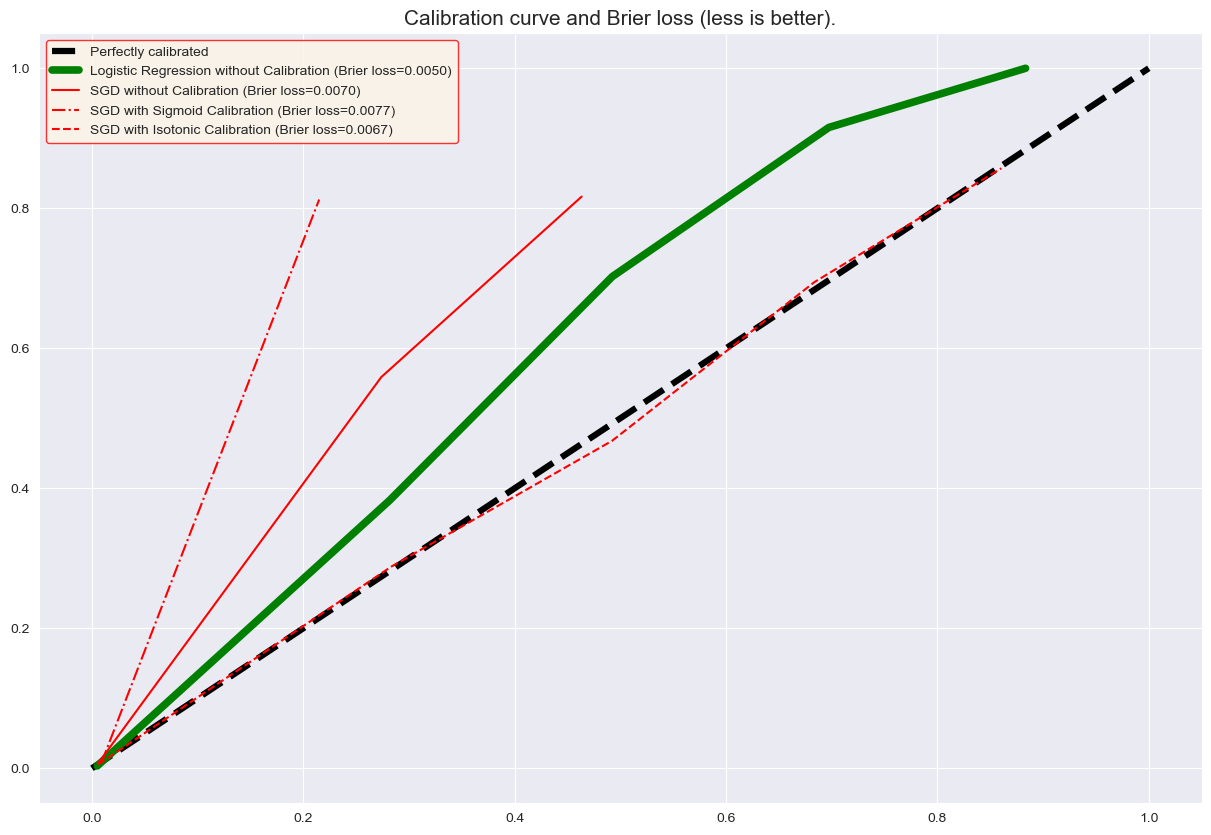

In [163]:
plt.figure(figsize=[15, 10])
plt.title('Calibration curve and Brier loss (less is better).', fontsize=15)
plt.plot([0,1],[0,1], linestyle='--', linewidth=4.5, color='black', label='Perfectly calibrated')

clf_lr_default_score = brier_score_loss(y_test, clf_lr_default_preds, pos_label=1)
plt.plot(prob_pred_lr_default, prob_true_lr_default, "g-",linewidth=5.5, label="Logistic Regression without Calibration (Brier loss={:.4f})".format(clf_lr_default_score))

clf_sgd_default_score = brier_score_loss(y_test, clf_sgd_default_preds, pos_label=1)
plt.plot(prob_pred_sgd_default, prob_true_sgd_default, "r-", label="SGD without Calibration (Brier loss={:.4f})".format(clf_sgd_default_score))
clf_sgd_sig_score = brier_score_loss(y_test, ccv_sgd_sig_preds, pos_label=1)
plt.plot(prob_pred_sgd_sig, prob_true_sgd_sig, "r-.", label="SGD with Sigmoid Calibration (Brier loss={:.4f})".format(clf_sgd_sig_score))
clf_sgd_iso_score = brier_score_loss(y_test, ccv_sgd_iso_preds, pos_label=1)
plt.plot(prob_pred_sgd_iso, prob_true_sgd_iso, "r--", label="SGD with Isotonic Calibration (Brier loss={:.4f})".format(clf_sgd_iso_score))

plt.legend(edgecolor = 'r',
           facecolor = 'oldlace')
plt.show();

In [164]:
del clf_lr_default, clf_lr_default_preds, prob_true_lr_default, prob_pred_lr_default, ccv_sgd_iso, ccv_sgd_iso_preds, prob_true_sgd_iso, prob_pred_sgd_iso, ccv_sgd_sig, ccv_sgd_sig_preds, prob_true_sgd_sig, prob_pred_sgd_sig, clf_sgd_default, clf_sgd_default_preds, prob_true_sgd_default, prob_pred_sgd_default

# RUN TEST

In [165]:
%%time
best_model = LogisticRegression(random_state=42, C=grid.best_params_['C'])
best_model.fit(updated_train, target)

CPU times: user 18.4 s, sys: 496 ms, total: 18.9 s
Wall time: 4.93 s


LogisticRegression(C=7.847599703514611, random_state=42)

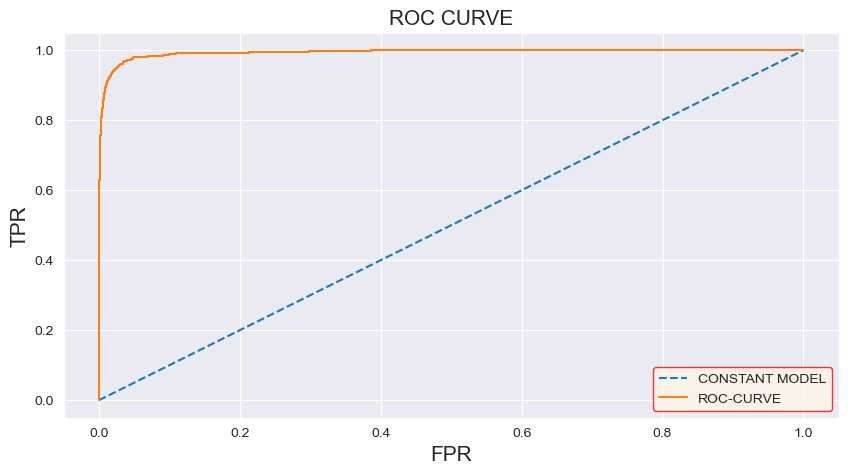

In [166]:
plt.figure(figsize=[10, 5])
plt.title('ROC CURVE', fontsize=15)
predictions = best_model.predict(x_test)
probalities = best_model.predict_proba(x_test)
probalities_one = probalities[:,1]
auc_roc = roc_auc_score(y_test, probalities_one)
plt.plot([0,1],[0,1], linestyle ='--', label='CONSTANT MODEL')
fpr, tpr, all_thresholds = roc_curve(y_test, probalities_one)
plt.plot(fpr, tpr, label=f'ROC-CURVE')
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.legend(edgecolor = 'r',
           facecolor = 'oldlace')
plt.show()

# PREDICTIONS

In [167]:
probalities = best_model.predict_proba(updated_test)
probalities_one = probalities[:,1]
output = pd.DataFrame(probalities_one, index = np.arange(1, probalities_one.shape[0] + 1), columns=['target'])
print(output.shape)

(82797, 1)


In [168]:
filename = '/Users/greygreywolf/Downloads/Alice_Predictions.csv'
output.to_csv(filename,index_label="session_id")
print('Saved file: ' + filename)

Saved file: /Users/greygreywolf/Downloads/Alice_Predictions.csv
